Dataset preview:
                          geometry  num_of_lines  avg_angle_of_intersection  \
0    POINT (30.1132479 81.9040127)             3                   1.569418   
1  POINT (30.11393889 81.90421187)             3                   0.000869   
2  POINT (30.13443475 81.92446576)             3                   0.000869   
3  POINT (30.12866542 81.91527886)             3                   0.001507   
4  POINT (30.10870486 81.90333917)             4                   2.092366   

   num_of_involved_line_intersections  \
0                                  20   
1                                  16   
2                                  16   
3                                  20   
4                                   7   

   vicinity_of_involved_line_intersections  min_distance_to_endpoint  \
0                                 0.006751                 30.167739   
1                                 0.005855                 30.168430   
2                                 0.025495   

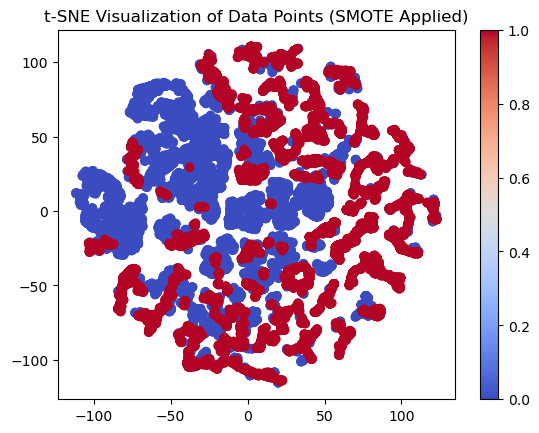

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv(r"C:/Users/twool/Downloads/intersection_analysis_2D.csv")

# Print dataset head for debugging
print(df.head())

# Convert is_point columns from TRUE/FALSE to 1/0
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Undersample label 0, keep all label 1
target_col = "error"
label_0 = df[df[target_col] == 0]
label_1 = df[df[target_col] == 1]

# Randomly sample 10,000 from label 0
label_0_sampled = label_0.sample(n=10000, random_state=42)
df_balanced = pd.concat([label_0_sampled, label_1], ignore_index=True)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Identify features and target
ignore_cols = ["geometry"]
print("Dataset preview:")
features = df_balanced.drop(columns=ignore_cols + [target_col])
target = df_balanced[target_col]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
features_smote, target_smote = smote.fit_resample(features_scaled, target)

# Function to evaluate unsupervised models
def evaluate_unsupervised_model(model_name, model, features_scaled, true_labels):
    y_pred = model.fit_predict(features_scaled)
    # For clustering methods, -1 indicates outliers (errors).
    # Convert predictions to binary (1 for error, 0 for non-error).
    y_pred_binary = (y_pred == -1).astype(int) if model_name in ["DBSCAN", "Isolation Forest"] else (y_pred > 0).astype(int)

    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

# 1. KMeans
kmeans = KMeans(n_clusters=70, random_state=42)
evaluate_unsupervised_model("KMeans", kmeans, features_smote, target_smote)

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
evaluate_unsupervised_model("DBSCAN", dbscan, features_smote, target_smote)

# 3. Isolation Forest
iso_forest = IsolationForest(random_state=42)
evaluate_unsupervised_model("Isolation Forest", iso_forest, features_smote, target_smote)

# 4. PCA + Anomaly Detection
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
features_pca = pca.fit_transform(features_smote)

# Use Local Outlier Factor (LOF) to detect anomalies in the reduced dimensional space
lof = LocalOutlierFactor(n_neighbors=5)
evaluate_unsupervised_model("PCA + LOF", lof, features_pca, target_smote)

# 5. t-SNE visualization (optional, for visual inspection)
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_smote)

# Visualize t-SNE plot
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=target_smote, cmap='coolwarm')
plt.colorbar()
plt.title("t-SNE Visualization of Data Points (SMOTE Applied)")
plt.show()


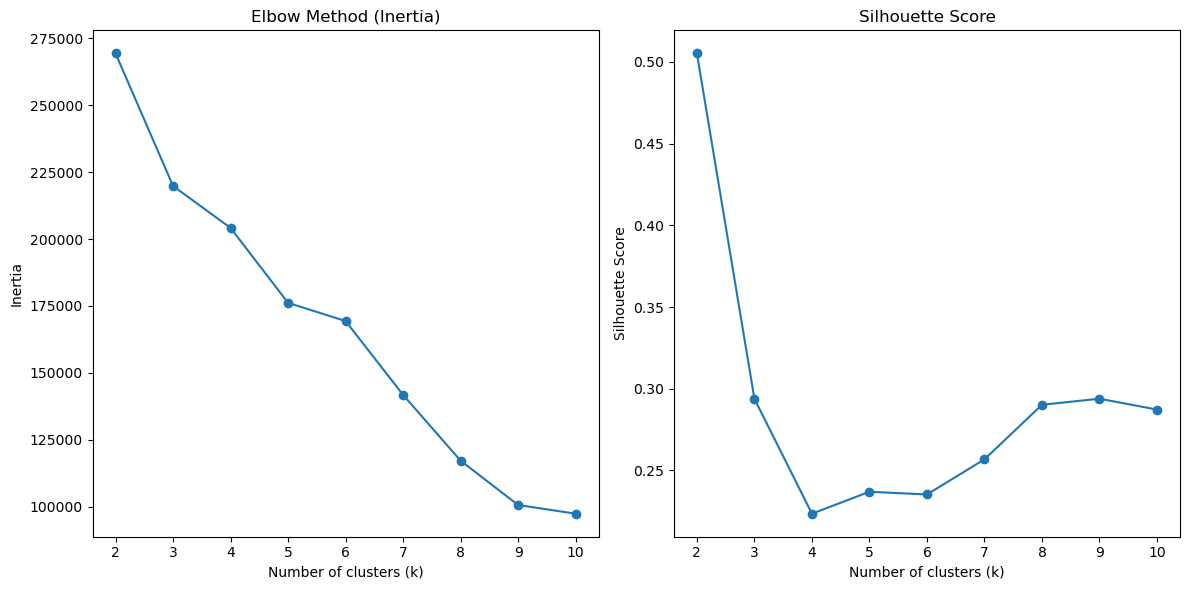

Optimal number of clusters based on Silhouette Score: 2
Best cluster as errors (Cluster 1):
Accuracy: 0.6318
F1 Score: 0.4516
False Positives: 397
False Negatives: 6968
Percentage of Errors Correctly Identified: 30.32%
              precision    recall  f1-score   support

           0       0.58      0.96      0.72     10000
           1       0.88      0.30      0.45     10000

    accuracy                           0.63     20000
   macro avg       0.73      0.63      0.59     20000
weighted avg       0.73      0.63      0.59     20000



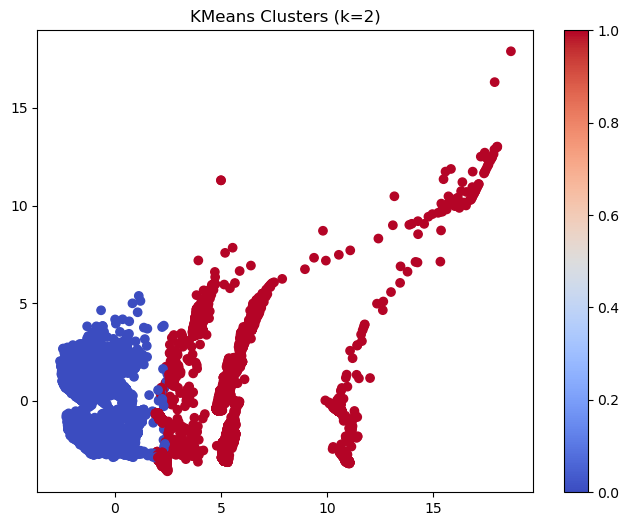

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv(r"C:/Users/twool/Downloads/intersection_analysis_2D.csv")

# Convert is_point columns from TRUE/FALSE to 1/0
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Undersample label 0, keep all label 1
target_col = "error"
label_0 = df[df[target_col] == 0]
label_1 = df[df[target_col] == 1]

# Randomly sample 10,000 from label 0
label_0_sampled = label_0.sample(n=10000, random_state=42)
df_balanced = pd.concat([label_0_sampled, label_1], ignore_index=True)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Identify features and target
ignore_cols = ["geometry"]
features = df_balanced.drop(columns=ignore_cols + [target_col])
target = df_balanced[target_col]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
features_smote, target_smote = smote.fit_resample(features_scaled, target)

# Function to evaluate the clustering model by treating each cluster as errors
def evaluate_kmeans_clustering(kmeans, features_scaled, true_labels):
    y_pred = kmeans.labels_  # Get cluster assignments (0, 1, 2, ...)
    
    best_accuracy = 0
    best_cluster = -1
    best_metrics = None
    best_y_pred_binary = None

    # Try each cluster as the "error" cluster and the rest as "non-error"
    for cluster in np.unique(y_pred):
        # Mark the cluster as errors (1) and the rest as non-errors (0)
        y_pred_binary = (y_pred == cluster).astype(int)
        
        # Compute the confusion matrix and evaluation metrics
        tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
        accuracy = accuracy_score(true_labels, y_pred_binary)
        percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster = cluster
            best_metrics = {
                "accuracy": accuracy,
                "f1_score": f1_score(true_labels, y_pred_binary),
                "false_positives": fp,
                "false_negatives": fn,
                "percent_errors_identified": percent_errors_identified,
            }
            best_y_pred_binary = y_pred_binary
    
    print(f"Best cluster as errors (Cluster {best_cluster}):")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"F1 Score: {best_metrics['f1_score']:.4f}")
    print(f"False Positives: {best_metrics['false_positives']}")
    print(f"False Negatives: {best_metrics['false_negatives']}")
    print(f"Percentage of Errors Correctly Identified: {best_metrics['percent_errors_identified']:.2f}%")
    print(classification_report(true_labels, best_y_pred_binary))

    return best_y_pred_binary, best_metrics


# 1. Find the best number of clusters using Elbow Method and Silhouette Score
def find_optimal_k(features_scaled):
    inertia = []
    silhouette_scores = []
    
    for k in range(2, 11):  # Test with k = 2 to 10 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        
        # Compute inertia (sum of squared distances to centroids)
        inertia.append(kmeans.inertia_)
        
        # Compute silhouette score
        silhouette = silhouette_score(features_scaled, kmeans.labels_)
        silhouette_scores.append(silhouette)
    
    # Plot Elbow Method (Inertia) and Silhouette Scores
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 11), inertia, marker='o')
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    
    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title("Silhouette Score")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    
    plt.tight_layout()
    plt.show()

    # Return optimal k based on maximum silhouette score
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # adding 2 to account for range starting at 2
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")
    
    return optimal_k


# Find the optimal k
optimal_k = find_optimal_k(features_smote)

# 2. Train KMeans with optimal k and evaluate
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(features_smote)

# Evaluate the clustering results
best_y_pred_binary, best_metrics = evaluate_kmeans_clustering(kmeans, features_smote, target_smote)

# 3. Visualize the clusters in 2D space (if PCA for dimensionality reduction is desired)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_smote)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=best_y_pred_binary, cmap='coolwarm')
plt.title(f"KMeans Clusters (k={optimal_k})")
plt.colorbar()
plt.show()


Accuracy: 0.6072
False Positives: 928
False Negatives: 6928
Percentage of Errors Correctly Identified: 30.72%
              precision    recall  f1-score   support

           0       0.57      0.91      0.70     10000
           1       0.77      0.31      0.44     10000

    accuracy                           0.61     20000
   macro avg       0.67      0.61      0.57     20000
weighted avg       0.67      0.61      0.57     20000



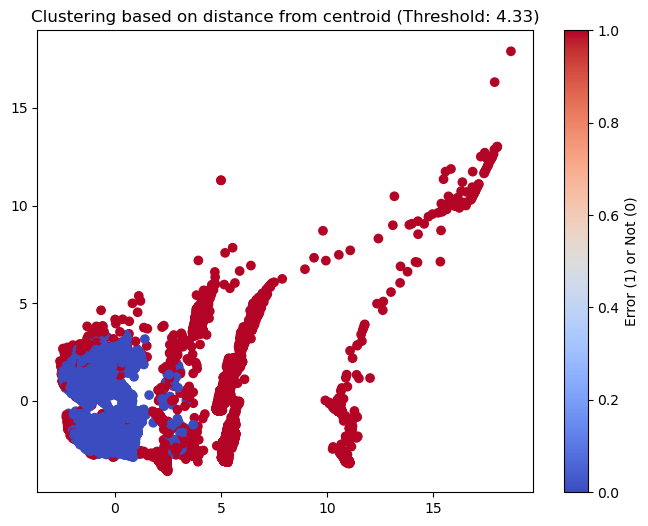

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# 1. Train KMeans with a single cluster (K=1)
def kmeans_single_cluster(features_scaled):
    kmeans = KMeans(n_clusters=1, random_state=42)
    kmeans.fit(features_scaled)
    
    # Get the centroid of the single cluster
    centroid = kmeans.cluster_centers_[0]
    
    # Calculate the distance of each point from the centroid
    distances = np.linalg.norm(features_scaled - centroid, axis=1)
    
    return distances, centroid

# 2. Determine errors based on distance from centroid (define "far" as being above a certain threshold)
def identify_errors_based_on_distance(distances, threshold_percentile=80):
    # Set the threshold as the 90th percentile of the distances
    threshold = np.percentile(distances, threshold_percentile)
    
    # Mark points that are far from the centroid as errors (1), and the rest as non-errors (0)
    y_pred_binary = (distances >= threshold).astype(int)
    
    return y_pred_binary, threshold

# 3. Evaluate the clustering results
def evaluate_kmeans_with_single_cluster(distances, y_pred_binary, true_labels):
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

# 4. Visualize the clusters (based on distance)
def visualize_clusters(features_scaled, distances, threshold, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Mark points that are errors (far from centroid)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(distances >= threshold), cmap='coolwarm')
    plt.title(f"Clustering based on distance from centroid (Threshold: {threshold:.2f})")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# 5. Apply SMOTE to balance the dataset
def apply_smote(features_scaled, target):
    smote = SMOTE(random_state=42)
    features_resampled, target_resampled = smote.fit_resample(features_scaled, target)
    return features_resampled, target_resampled

# Apply SMOTE to generate synthetic samples
features_resampled, target_resampled = apply_smote(features_scaled, target)

# Train KMeans with a single cluster on the resampled data
distances, centroid = kmeans_single_cluster(features_resampled)

# Identify errors based on distance from centroid
y_pred_binary, threshold = identify_errors_based_on_distance(distances)

# Evaluate the clustering results
evaluate_kmeans_with_single_cluster(distances, y_pred_binary, target_resampled)

# Visualize the clustering result
visualize_clusters(features_resampled, distances, threshold)


Accuracy: 0.3683
False Positives: 9603
False Negatives: 3032
Percentage of Errors Correctly Identified: 69.68%
              precision    recall  f1-score   support

           0       0.12      0.04      0.06     10000
           1       0.42      0.70      0.52     10000

    accuracy                           0.37     20000
   macro avg       0.27      0.37      0.29     20000
weighted avg       0.27      0.37      0.29     20000



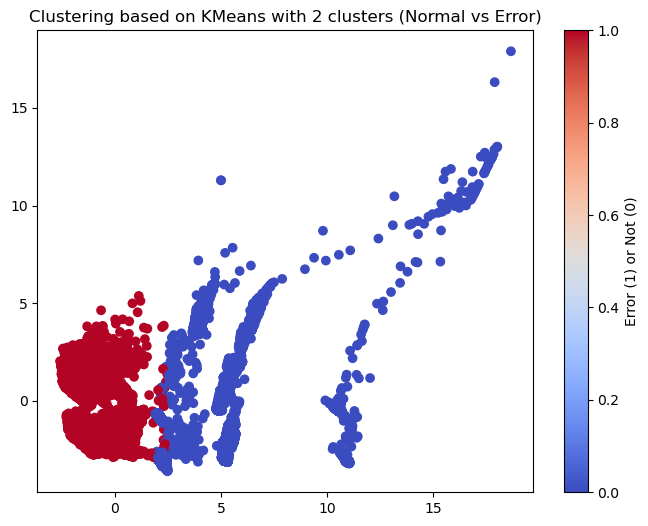

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Train KMeans with 2 clusters (normal and error)
def kmeans_two_clusters(features_scaled):
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(features_scaled)
    
    # Get the cluster labels (0 and 1)
    cluster_labels = kmeans.labels_
    
    # Count the number of points in each cluster
    cluster_sizes = np.bincount(cluster_labels)
    
    # Assuming the larger cluster is the "normal" cluster (0) and the smaller one is the "error" cluster (1)
    normal_cluster = np.argmin(cluster_sizes)  # smaller cluster is considered "error"
    
    return cluster_labels, normal_cluster

# 2. Evaluate the clustering results
def evaluate_kmeans_with_two_clusters(cluster_labels, normal_cluster, true_labels):
    # Mark points in the "error" cluster (not the "normal" cluster)
    y_pred_binary = (cluster_labels != normal_cluster).astype(int)  # Error cluster as 1, normal as 0
    
    # Confusion matrix and performance metrics
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

# 3. Visualize the clusters (based on cluster labels)
def visualize_clusters(features_scaled, cluster_labels, normal_cluster, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot the data points, color-coded by their cluster label (normal vs. error)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(cluster_labels != normal_cluster), cmap='coolwarm')
    plt.title("Clustering based on KMeans with 2 clusters (Normal vs Error)")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Train KMeans with 2 clusters (normal and error)
cluster_labels, normal_cluster = kmeans_two_clusters(features_resampled)

# Evaluate the clustering results
evaluate_kmeans_with_two_clusters(cluster_labels, normal_cluster, target_resampled)

# Visualize the clustering result
visualize_clusters(features_resampled, cluster_labels, normal_cluster)



KMeans (2 clusters)
KMeans (2 clusters) - Evaluation Metrics:
Accuracy: 0.3683
False Positives: 9603
False Negatives: 3032
Percentage of Errors Correctly Identified: 69.68%
              precision    recall  f1-score   support

           0       0.12      0.04      0.06     10000
           1       0.42      0.70      0.52     10000

    accuracy                           0.37     20000
   macro avg       0.27      0.37      0.29     20000
weighted avg       0.27      0.37      0.29     20000



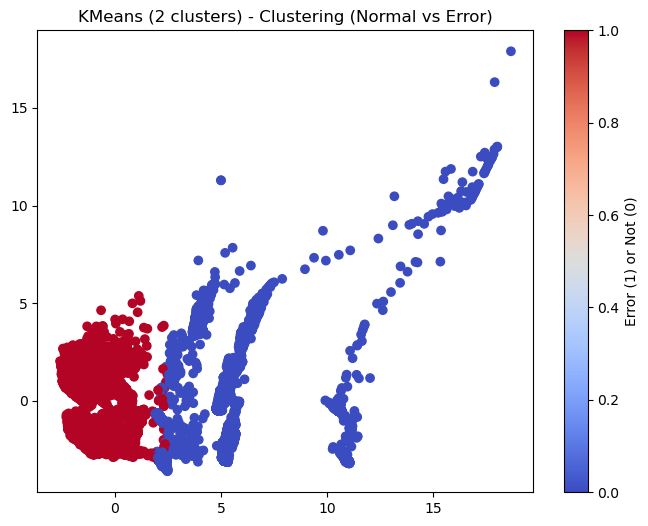


DBSCAN
DBSCAN - Evaluation Metrics:
Accuracy: 0.5000
False Positives: 10000
False Negatives: 0
Percentage of Errors Correctly Identified: 100.00%


C:\Users\twool\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\twool\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\twool\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.50      1.00      0.67     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



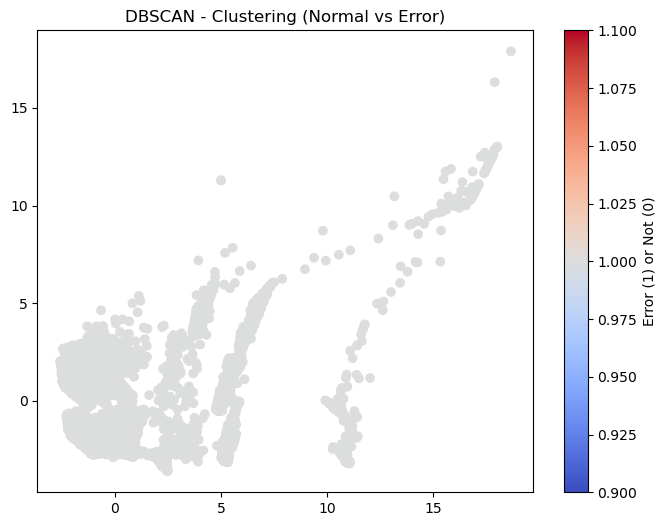


Agglomerative Clustering (2 clusters)
Agglomerative Clustering (2 clusters) - Evaluation Metrics:
Accuracy: 0.3797
False Positives: 9902
False Negatives: 2504
Percentage of Errors Correctly Identified: 74.96%
              precision    recall  f1-score   support

           0       0.04      0.01      0.02     10000
           1       0.43      0.75      0.55     10000

    accuracy                           0.38     20000
   macro avg       0.23      0.38      0.28     20000
weighted avg       0.23      0.38      0.28     20000



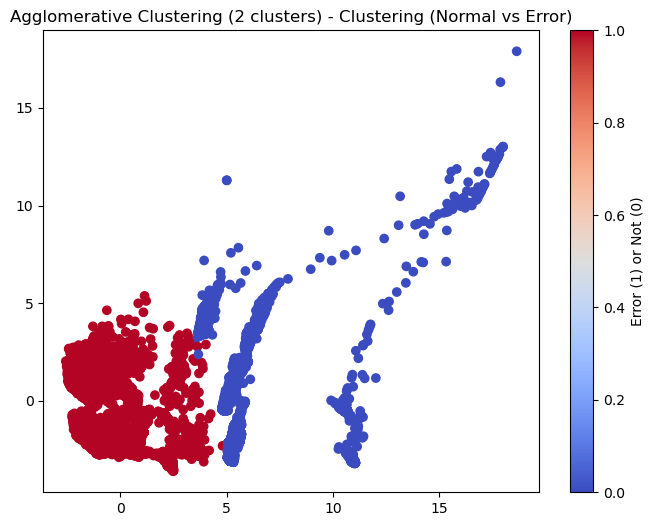


Gaussian Mixture Model (2 components)
Gaussian Mixture Model (2 components) - Evaluation Metrics:
Accuracy: 0.3353
False Positives: 9062
False Negatives: 4232
Percentage of Errors Correctly Identified: 57.68%
              precision    recall  f1-score   support

           0       0.18      0.09      0.12     10000
           1       0.39      0.58      0.46     10000

    accuracy                           0.34     20000
   macro avg       0.29      0.34      0.29     20000
weighted avg       0.29      0.34      0.29     20000



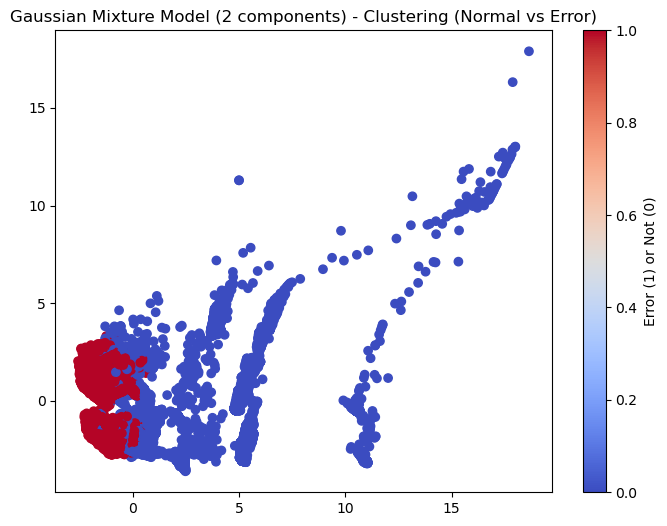


Mean Shift
Mean Shift - Evaluation Metrics:
Accuracy: 0.5000
False Positives: 9999
False Negatives: 0
Percentage of Errors Correctly Identified: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     10000
           1       0.50      1.00      0.67     10000

    accuracy                           0.50     20000
   macro avg       0.75      0.50      0.33     20000
weighted avg       0.75      0.50      0.33     20000



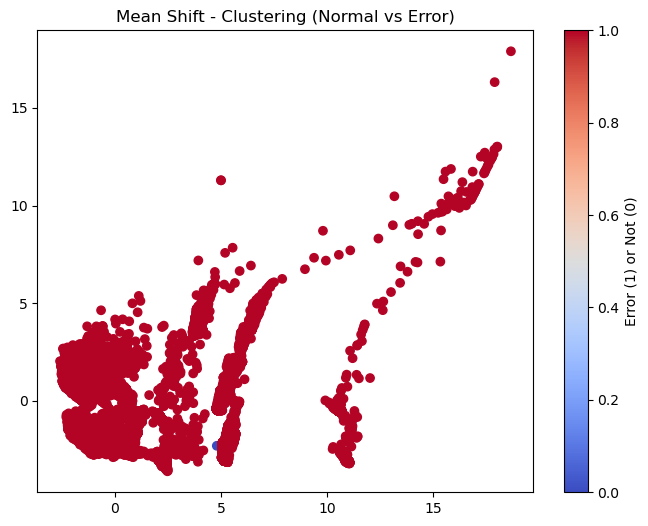

In [19]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define a function to evaluate and visualize each clustering method
def evaluate_and_visualize_clustering(clustering_model, name, features_scaled, true_labels):
    # Fit the model
    clustering_model.fit(features_scaled)
    
    # Get the cluster labels
    cluster_labels = clustering_model.labels_ if hasattr(clustering_model, 'labels_') else clustering_model.predict(features_scaled)
    
    # Handle DBSCAN noise (-1) and treat it as errors
    if np.any(cluster_labels == -1):
        cluster_labels = np.where(cluster_labels == -1, len(set(cluster_labels)), cluster_labels)  # Convert -1 (noise) to a new cluster
    
    # Assume the cluster with the fewer points is the error cluster (and the other is the normal cluster)
    cluster_sizes = np.bincount(cluster_labels)
    normal_cluster = np.argmin(cluster_sizes)  # Smaller cluster is assumed to be error
    
    # Mark errors (everything in the error cluster is marked as error)
    y_pred_binary = (cluster_labels != normal_cluster).astype(int)  # Error cluster as 1, normal as 0
    
    # Evaluation metrics
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"{name} - Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))
    
    # Visualize the clusters
    visualize_clusters(features_scaled, cluster_labels, normal_cluster, name)

# Define a function for visualizing the clustering results
def visualize_clusters(features_scaled, cluster_labels, normal_cluster, model_name, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot the data points, color-coded by their cluster label (normal vs. error)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(cluster_labels != normal_cluster), cmap='coolwarm')
    plt.title(f"{model_name} - Clustering (Normal vs Error)")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Try different clustering methods
clustering_models = [
    (KMeans(n_clusters=2, random_state=42), "KMeans (2 clusters)"),
    (DBSCAN(), "DBSCAN"),
    (AgglomerativeClustering(n_clusters=2), "Agglomerative Clustering (2 clusters)"),
    (GaussianMixture(n_components=2, random_state=42), "Gaussian Mixture Model (2 components)"),
    (MeanShift(), "Mean Shift")
]

# Iterate over clustering models and evaluate them
for model, name in clustering_models:
    print(f"\n{ '='*50 }\n{name}")
    evaluate_and_visualize_clustering(model, name, features_resampled, target_resampled)



Evaluating with 2 clusters...

KMeans - 2 clusters, Error Cluster: 0
Accuracy: 0.3683
False Positives: 9603
False Negatives: 3032
Percentage of Errors Correctly Identified: 69.68%
              precision    recall  f1-score   support

           0       0.12      0.04      0.06     10000
           1       0.42      0.70      0.52     10000

    accuracy                           0.37     20000
   macro avg       0.27      0.37      0.29     20000
weighted avg       0.27      0.37      0.29     20000



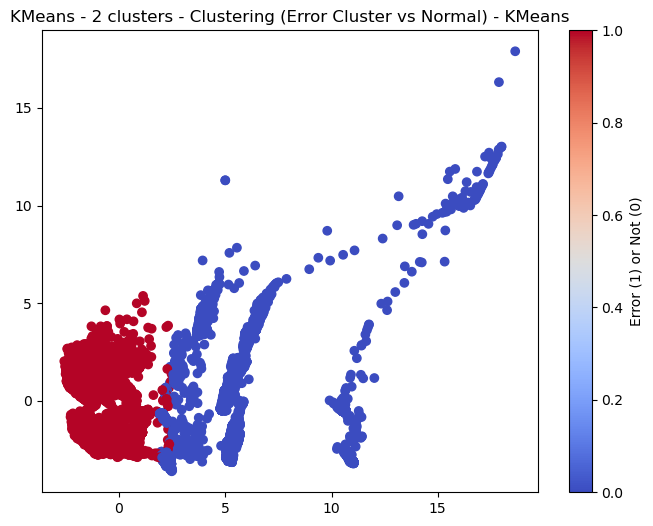


KMeans - 2 clusters, Error Cluster: 1
Accuracy: 0.6318
False Positives: 397
False Negatives: 6968
Percentage of Errors Correctly Identified: 30.32%
              precision    recall  f1-score   support

           0       0.58      0.96      0.72     10000
           1       0.88      0.30      0.45     10000

    accuracy                           0.63     20000
   macro avg       0.73      0.63      0.59     20000
weighted avg       0.73      0.63      0.59     20000



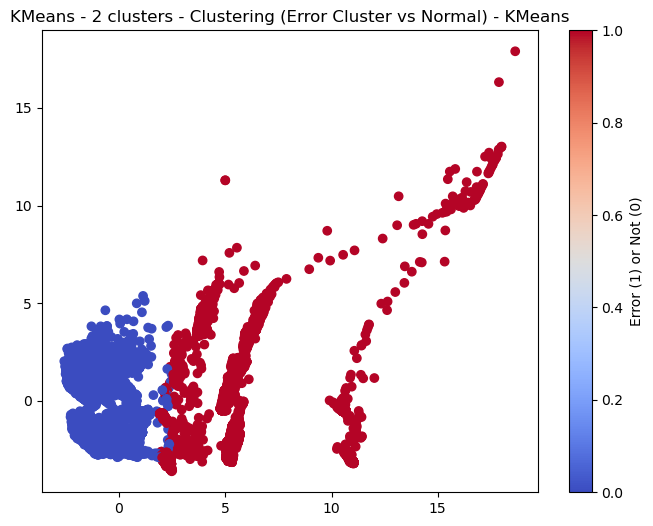


Evaluating with 3 clusters...

KMeans - 3 clusters, Error Cluster: 0
Accuracy: 0.3100
False Positives: 7437
False Negatives: 6363
Percentage of Errors Correctly Identified: 36.37%
              precision    recall  f1-score   support

           0       0.29      0.26      0.27     10000
           1       0.33      0.36      0.35     10000

    accuracy                           0.31     20000
   macro avg       0.31      0.31      0.31     20000
weighted avg       0.31      0.31      0.31     20000



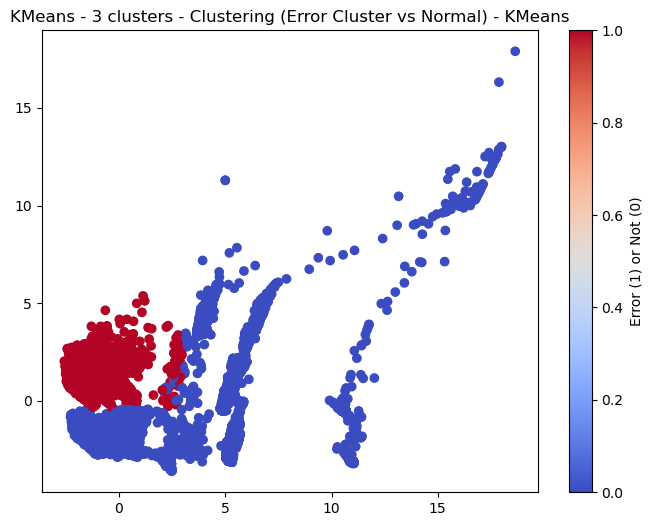


KMeans - 3 clusters, Error Cluster: 1
Accuracy: 0.6178
False Positives: 149
False Negatives: 7496
Percentage of Errors Correctly Identified: 25.04%
              precision    recall  f1-score   support

           0       0.57      0.99      0.72     10000
           1       0.94      0.25      0.40     10000

    accuracy                           0.62     20000
   macro avg       0.76      0.62      0.56     20000
weighted avg       0.76      0.62      0.56     20000



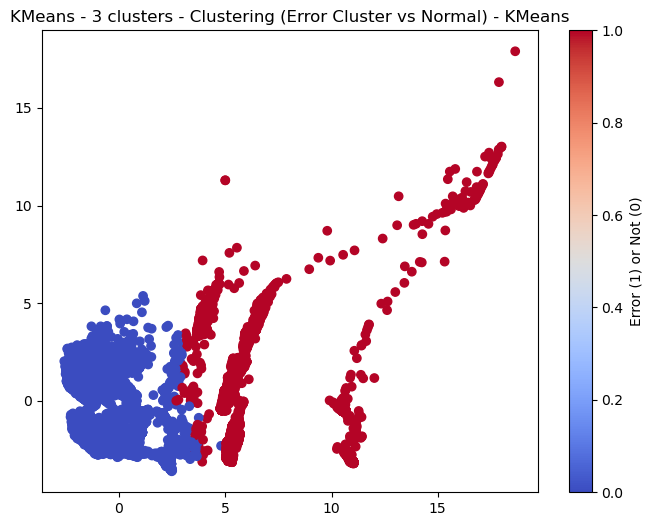


KMeans - 3 clusters, Error Cluster: 2
Accuracy: 0.5723
False Positives: 2414
False Negatives: 6141
Percentage of Errors Correctly Identified: 38.59%
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     10000
           1       0.62      0.39      0.47     10000

    accuracy                           0.57     20000
   macro avg       0.58      0.57      0.56     20000
weighted avg       0.58      0.57      0.56     20000



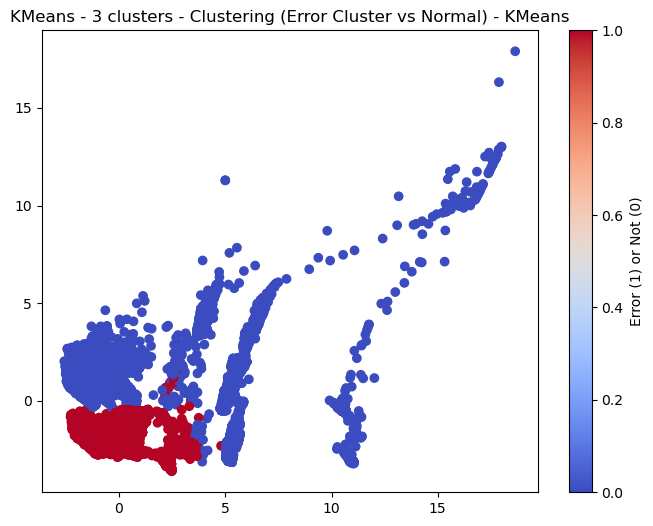


Evaluating with 4 clusters...

KMeans - 4 clusters, Error Cluster: 0
Accuracy: 0.4887
False Positives: 2450
False Negatives: 7776
Percentage of Errors Correctly Identified: 22.24%
              precision    recall  f1-score   support

           0       0.49      0.76      0.60     10000
           1       0.48      0.22      0.30     10000

    accuracy                           0.49     20000
   macro avg       0.48      0.49      0.45     20000
weighted avg       0.48      0.49      0.45     20000



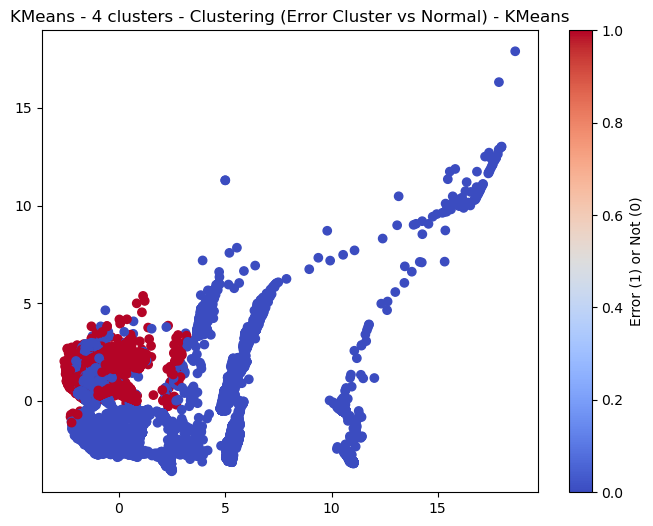


KMeans - 4 clusters, Error Cluster: 1
Accuracy: 0.6179
False Positives: 145
False Negatives: 7496
Percentage of Errors Correctly Identified: 25.04%
              precision    recall  f1-score   support

           0       0.57      0.99      0.72     10000
           1       0.95      0.25      0.40     10000

    accuracy                           0.62     20000
   macro avg       0.76      0.62      0.56     20000
weighted avg       0.76      0.62      0.56     20000



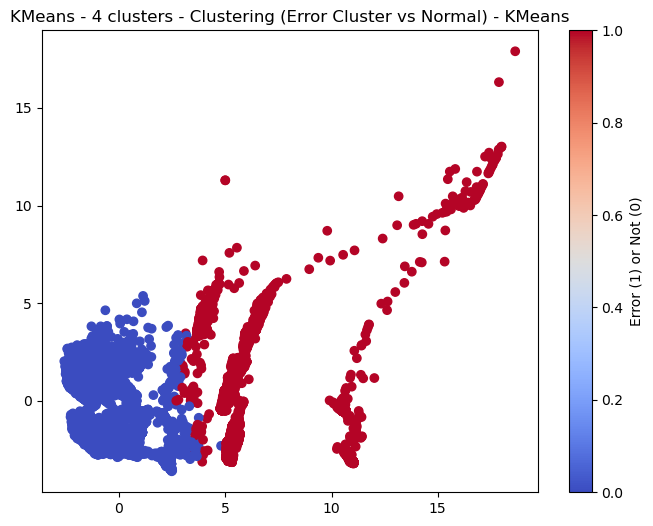


KMeans - 4 clusters, Error Cluster: 2
Accuracy: 0.3205
False Positives: 5003
False Negatives: 8587
Percentage of Errors Correctly Identified: 14.13%
              precision    recall  f1-score   support

           0       0.37      0.50      0.42     10000
           1       0.22      0.14      0.17     10000

    accuracy                           0.32     20000
   macro avg       0.29      0.32      0.30     20000
weighted avg       0.29      0.32      0.30     20000



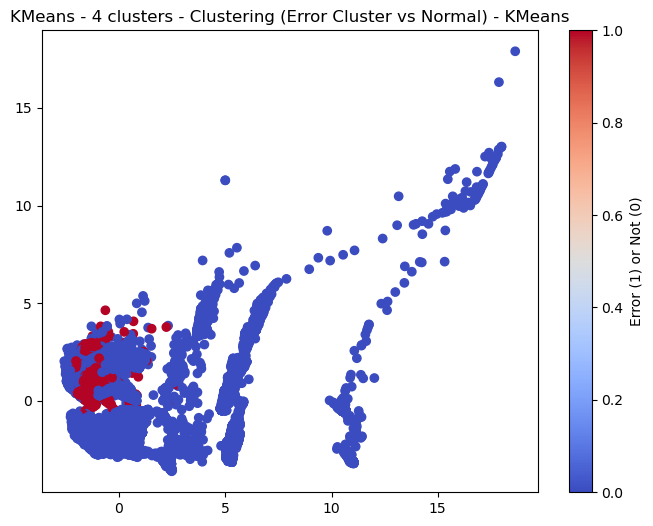


KMeans - 4 clusters, Error Cluster: 3
Accuracy: 0.5728
False Positives: 2402
False Negatives: 6141
Percentage of Errors Correctly Identified: 38.59%
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     10000
           1       0.62      0.39      0.47     10000

    accuracy                           0.57     20000
   macro avg       0.58      0.57      0.56     20000
weighted avg       0.58      0.57      0.56     20000



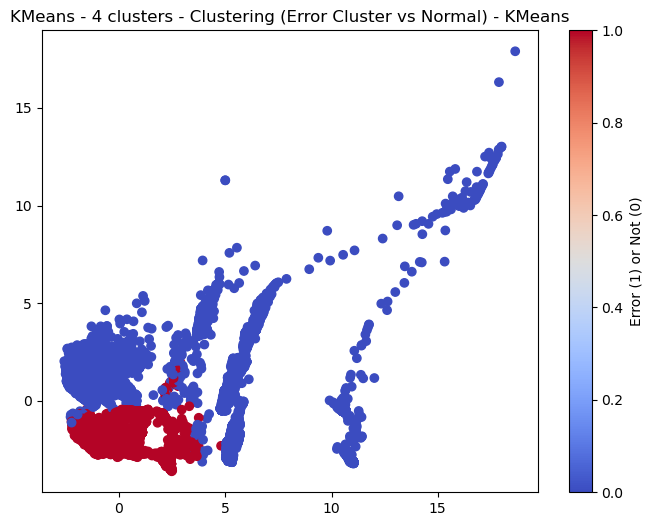


Evaluating with 5 clusters...

KMeans - 5 clusters, Error Cluster: 0
Accuracy: 0.4887
False Positives: 2445
False Negatives: 7781
Percentage of Errors Correctly Identified: 22.19%
              precision    recall  f1-score   support

           0       0.49      0.76      0.60     10000
           1       0.48      0.22      0.30     10000

    accuracy                           0.49     20000
   macro avg       0.48      0.49      0.45     20000
weighted avg       0.48      0.49      0.45     20000



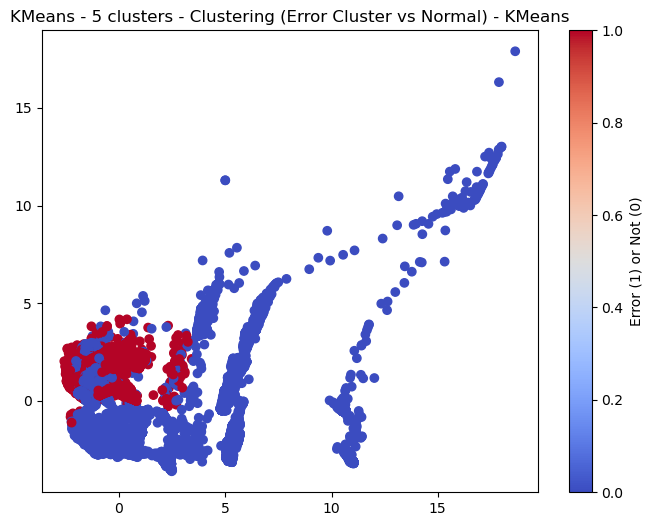


KMeans - 5 clusters, Error Cluster: 1
Accuracy: 0.5920
False Positives: 103
False Negatives: 8056
Percentage of Errors Correctly Identified: 19.44%
              precision    recall  f1-score   support

           0       0.55      0.99      0.71     10000
           1       0.95      0.19      0.32     10000

    accuracy                           0.59     20000
   macro avg       0.75      0.59      0.52     20000
weighted avg       0.75      0.59      0.52     20000



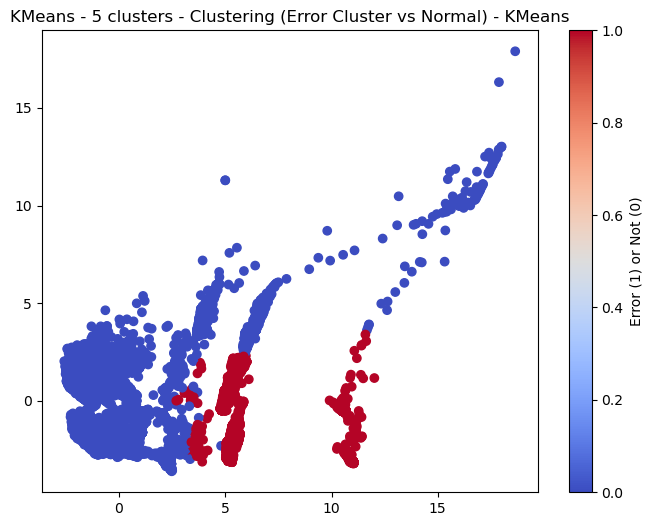


KMeans - 5 clusters, Error Cluster: 2
Accuracy: 0.3206
False Positives: 5006
False Negatives: 8582
Percentage of Errors Correctly Identified: 14.18%
              precision    recall  f1-score   support

           0       0.37      0.50      0.42     10000
           1       0.22      0.14      0.17     10000

    accuracy                           0.32     20000
   macro avg       0.29      0.32      0.30     20000
weighted avg       0.29      0.32      0.30     20000



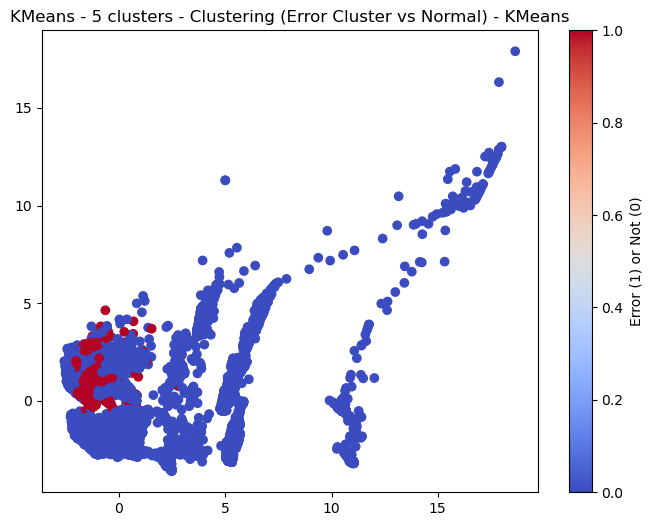


KMeans - 5 clusters, Error Cluster: 3
Accuracy: 0.5733
False Positives: 2393
False Negatives: 6141
Percentage of Errors Correctly Identified: 38.59%
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     10000
           1       0.62      0.39      0.47     10000

    accuracy                           0.57     20000
   macro avg       0.59      0.57      0.56     20000
weighted avg       0.59      0.57      0.56     20000



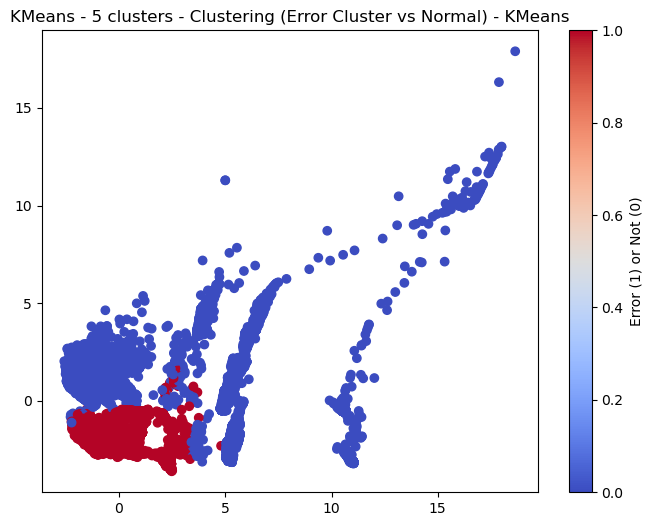


KMeans - 5 clusters, Error Cluster: 4
Accuracy: 0.5253
False Positives: 53
False Negatives: 9440
Percentage of Errors Correctly Identified: 5.60%
              precision    recall  f1-score   support

           0       0.51      0.99      0.68     10000
           1       0.91      0.06      0.11     10000

    accuracy                           0.53     20000
   macro avg       0.71      0.53      0.39     20000
weighted avg       0.71      0.53      0.39     20000



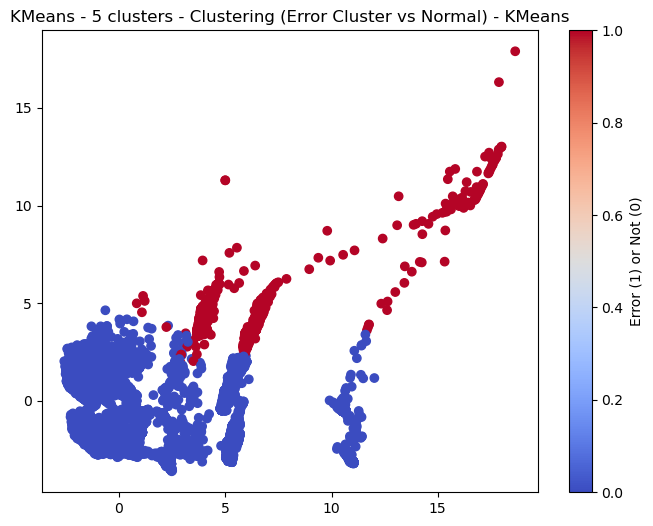


Evaluating with 2 clusters...

DBSCAN - 2 clusters, Error Cluster: 0
Accuracy: 0.4847
False Positives: 306
False Negatives: 10000
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.49      0.97      0.65     10000
           1       0.00      0.00      0.00     10000

    accuracy                           0.48     20000
   macro avg       0.25      0.48      0.33     20000
weighted avg       0.25      0.48      0.33     20000



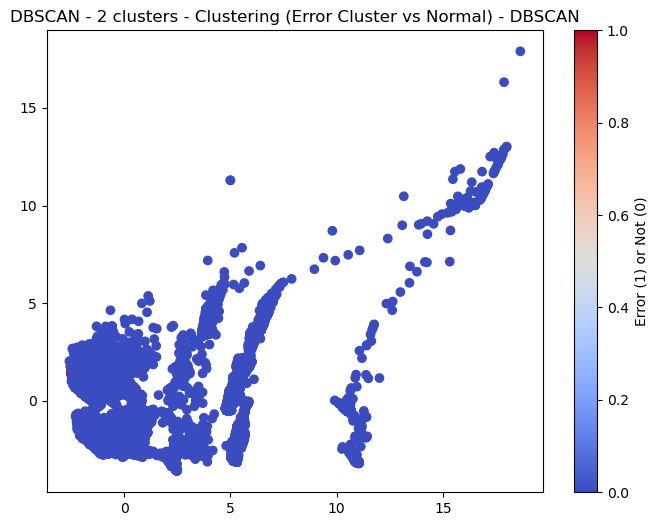


DBSCAN - 2 clusters, Error Cluster: 1
Accuracy: 0.5159
False Positives: 4
False Negatives: 9679
Percentage of Errors Correctly Identified: 3.21%
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.99      0.03      0.06     10000

    accuracy                           0.52     20000
   macro avg       0.75      0.52      0.37     20000
weighted avg       0.75      0.52      0.37     20000



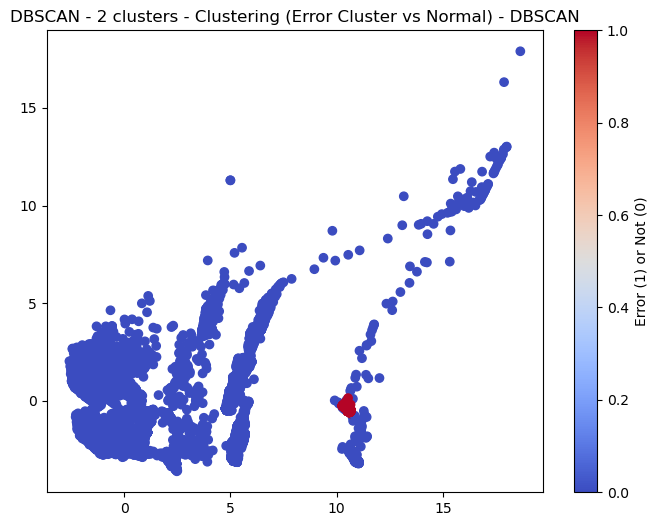


Evaluating with 3 clusters...

DBSCAN - 3 clusters, Error Cluster: 0
Accuracy: 0.4847
False Positives: 306
False Negatives: 10000
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.49      0.97      0.65     10000
           1       0.00      0.00      0.00     10000

    accuracy                           0.48     20000
   macro avg       0.25      0.48      0.33     20000
weighted avg       0.25      0.48      0.33     20000



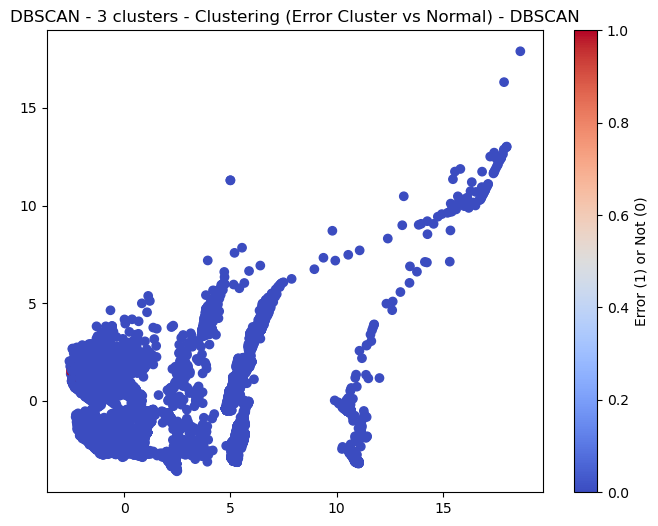


DBSCAN - 3 clusters, Error Cluster: 1
Accuracy: 0.5159
False Positives: 4
False Negatives: 9679
Percentage of Errors Correctly Identified: 3.21%
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.99      0.03      0.06     10000

    accuracy                           0.52     20000
   macro avg       0.75      0.52      0.37     20000
weighted avg       0.75      0.52      0.37     20000



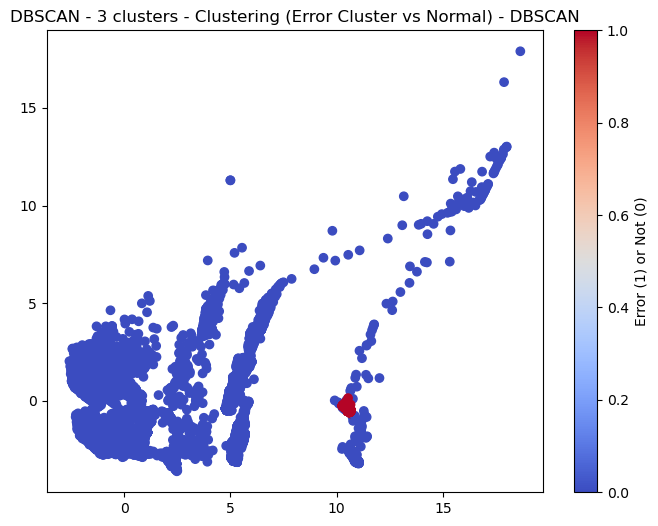


DBSCAN - 3 clusters, Error Cluster: 2
Accuracy: 0.4346
False Positives: 1614
False Negatives: 9693
Percentage of Errors Correctly Identified: 3.07%
              precision    recall  f1-score   support

           0       0.46      0.84      0.60     10000
           1       0.16      0.03      0.05     10000

    accuracy                           0.43     20000
   macro avg       0.31      0.43      0.32     20000
weighted avg       0.31      0.43      0.32     20000



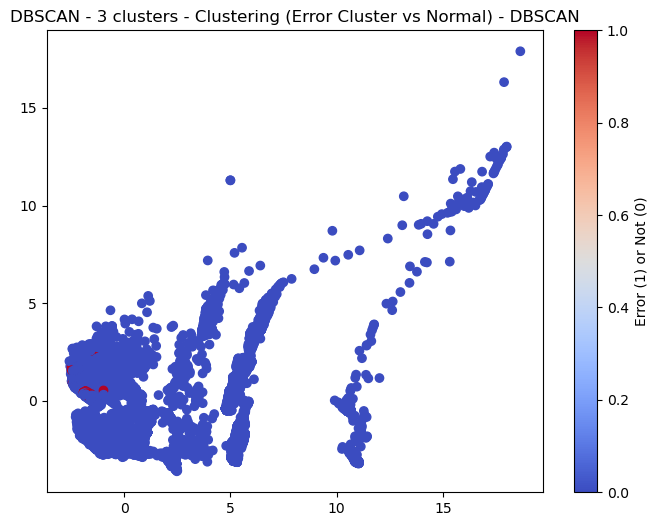


Evaluating with 4 clusters...

DBSCAN - 4 clusters, Error Cluster: 0
Accuracy: 0.4847
False Positives: 306
False Negatives: 10000
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.49      0.97      0.65     10000
           1       0.00      0.00      0.00     10000

    accuracy                           0.48     20000
   macro avg       0.25      0.48      0.33     20000
weighted avg       0.25      0.48      0.33     20000



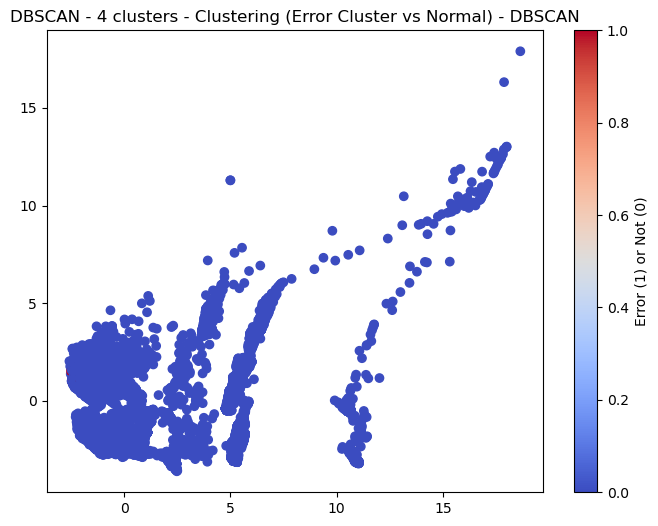


DBSCAN - 4 clusters, Error Cluster: 1
Accuracy: 0.5159
False Positives: 4
False Negatives: 9679
Percentage of Errors Correctly Identified: 3.21%
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.99      0.03      0.06     10000

    accuracy                           0.52     20000
   macro avg       0.75      0.52      0.37     20000
weighted avg       0.75      0.52      0.37     20000



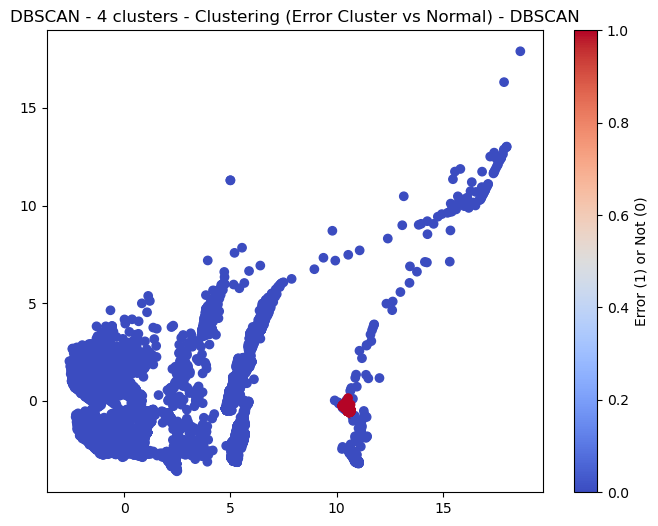


DBSCAN - 4 clusters, Error Cluster: 2
Accuracy: 0.4346
False Positives: 1614
False Negatives: 9693
Percentage of Errors Correctly Identified: 3.07%
              precision    recall  f1-score   support

           0       0.46      0.84      0.60     10000
           1       0.16      0.03      0.05     10000

    accuracy                           0.43     20000
   macro avg       0.31      0.43      0.32     20000
weighted avg       0.31      0.43      0.32     20000



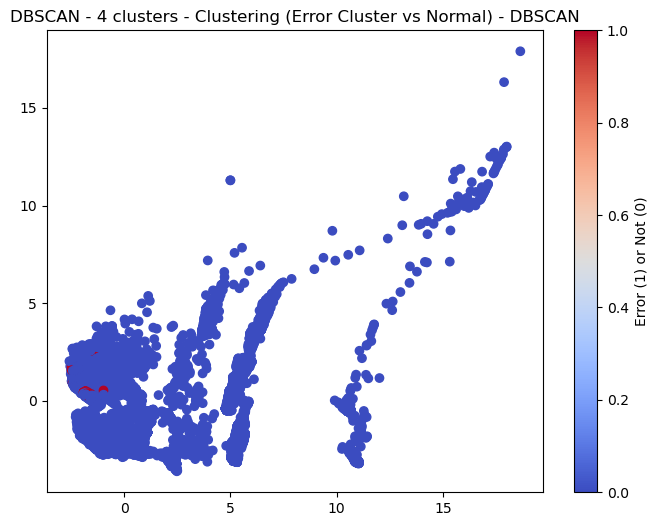


DBSCAN - 4 clusters, Error Cluster: 3
Accuracy: 0.5183
False Positives: 0
False Negatives: 9634
Percentage of Errors Correctly Identified: 3.66%
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       1.00      0.04      0.07     10000

    accuracy                           0.52     20000
   macro avg       0.75      0.52      0.37     20000
weighted avg       0.75      0.52      0.37     20000



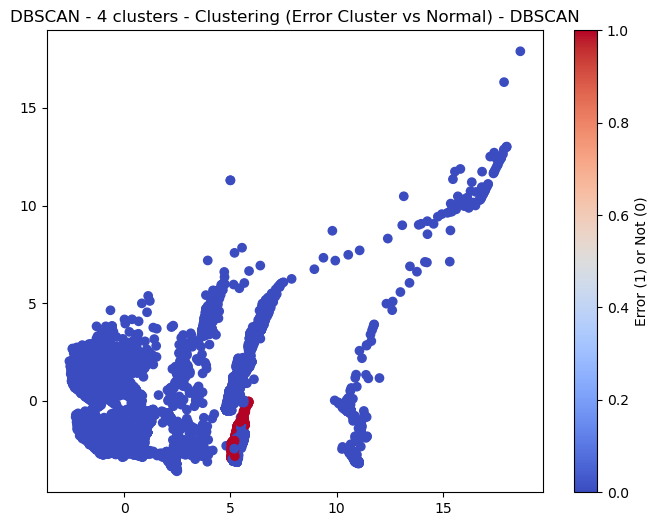


Evaluating with 5 clusters...

DBSCAN - 5 clusters, Error Cluster: 0
Accuracy: 0.4847
False Positives: 306
False Negatives: 10000
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.49      0.97      0.65     10000
           1       0.00      0.00      0.00     10000

    accuracy                           0.48     20000
   macro avg       0.25      0.48      0.33     20000
weighted avg       0.25      0.48      0.33     20000



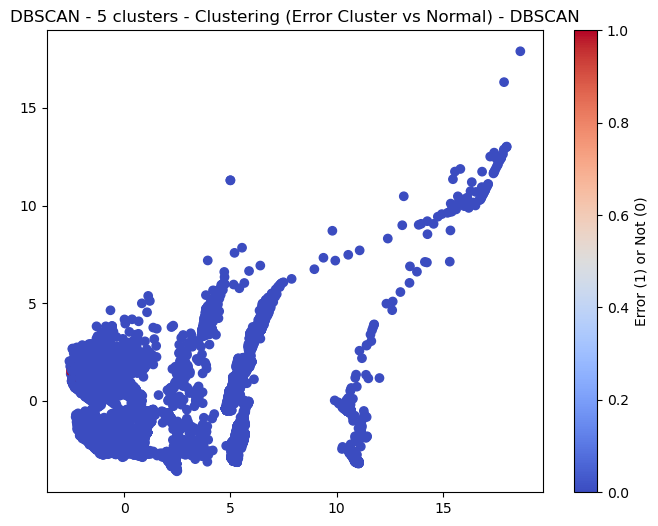


DBSCAN - 5 clusters, Error Cluster: 1
Accuracy: 0.5159
False Positives: 4
False Negatives: 9679
Percentage of Errors Correctly Identified: 3.21%
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       0.99      0.03      0.06     10000

    accuracy                           0.52     20000
   macro avg       0.75      0.52      0.37     20000
weighted avg       0.75      0.52      0.37     20000



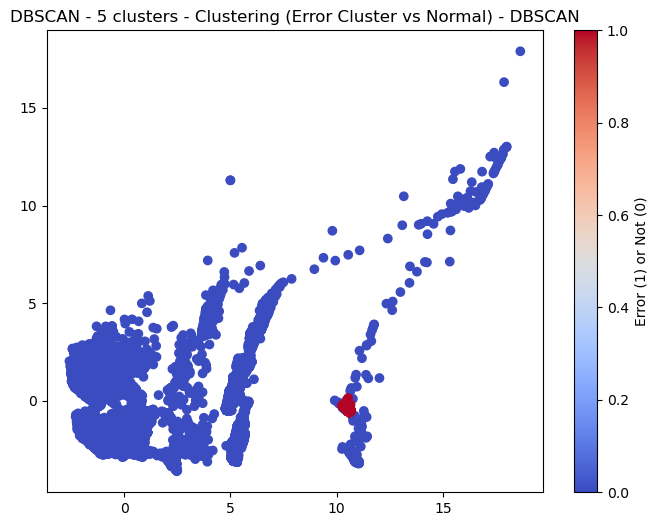


DBSCAN - 5 clusters, Error Cluster: 2
Accuracy: 0.4346
False Positives: 1614
False Negatives: 9693
Percentage of Errors Correctly Identified: 3.07%
              precision    recall  f1-score   support

           0       0.46      0.84      0.60     10000
           1       0.16      0.03      0.05     10000

    accuracy                           0.43     20000
   macro avg       0.31      0.43      0.32     20000
weighted avg       0.31      0.43      0.32     20000



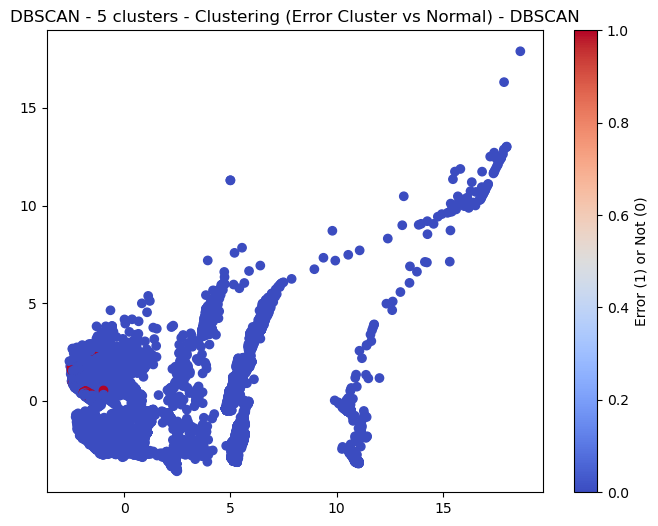


DBSCAN - 5 clusters, Error Cluster: 3
Accuracy: 0.5183
False Positives: 0
False Negatives: 9634
Percentage of Errors Correctly Identified: 3.66%
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10000
           1       1.00      0.04      0.07     10000

    accuracy                           0.52     20000
   macro avg       0.75      0.52      0.37     20000
weighted avg       0.75      0.52      0.37     20000



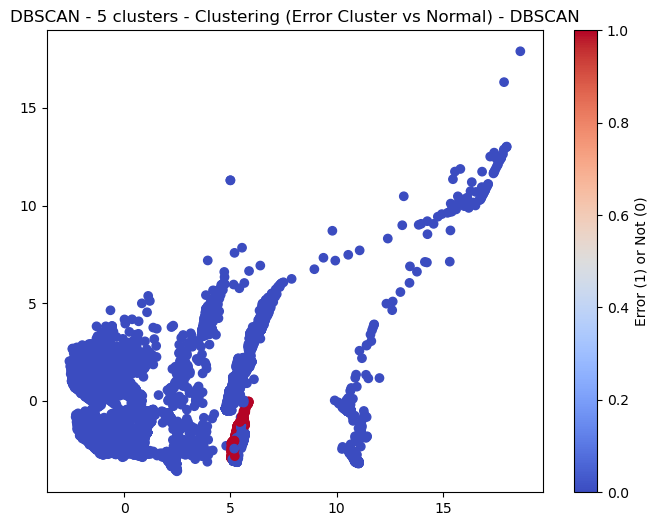


DBSCAN - 5 clusters, Error Cluster: 4
Accuracy: 0.3982
False Positives: 3377
False Negatives: 8659
Percentage of Errors Correctly Identified: 13.41%
              precision    recall  f1-score   support

           0       0.43      0.66      0.52     10000
           1       0.28      0.13      0.18     10000

    accuracy                           0.40     20000
   macro avg       0.36      0.40      0.35     20000
weighted avg       0.36      0.40      0.35     20000



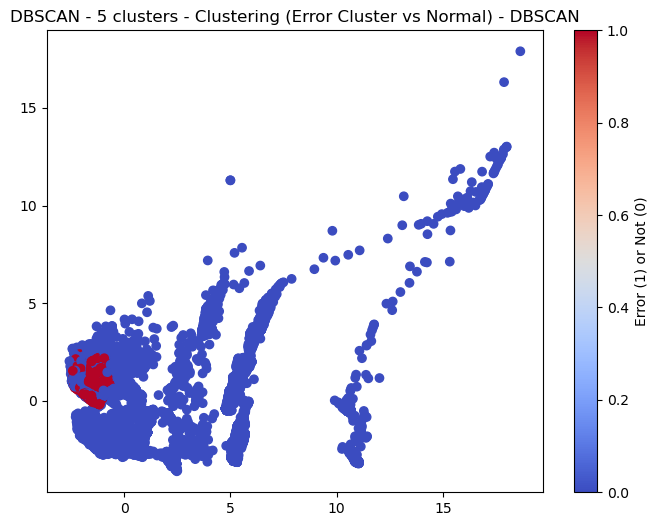


Evaluating with 2 clusters...

Agglomerative Clustering - 2 clusters, Error Cluster: 0
Accuracy: 0.3797
False Positives: 9902
False Negatives: 2504
Percentage of Errors Correctly Identified: 74.96%
              precision    recall  f1-score   support

           0       0.04      0.01      0.02     10000
           1       0.43      0.75      0.55     10000

    accuracy                           0.38     20000
   macro avg       0.23      0.38      0.28     20000
weighted avg       0.23      0.38      0.28     20000



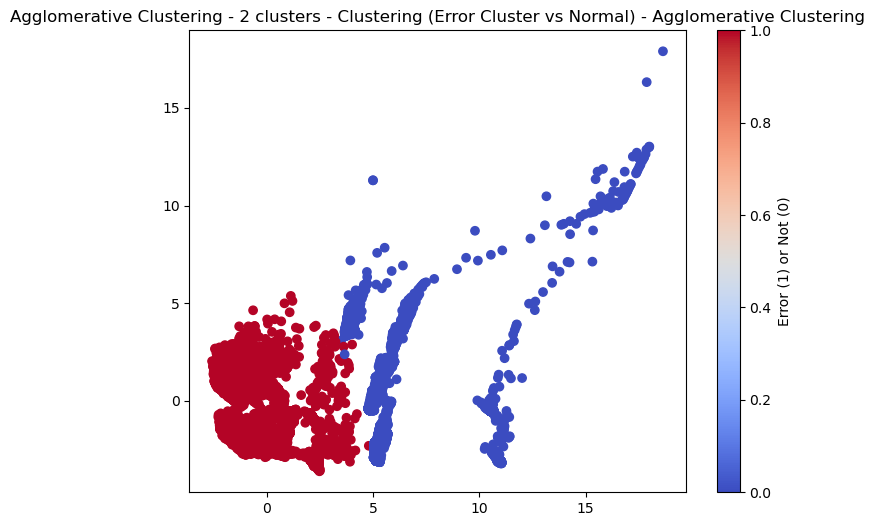


Agglomerative Clustering - 2 clusters, Error Cluster: 1
Accuracy: 0.6203
False Positives: 98
False Negatives: 7496
Percentage of Errors Correctly Identified: 25.04%
              precision    recall  f1-score   support

           0       0.57      0.99      0.72     10000
           1       0.96      0.25      0.40     10000

    accuracy                           0.62     20000
   macro avg       0.77      0.62      0.56     20000
weighted avg       0.77      0.62      0.56     20000



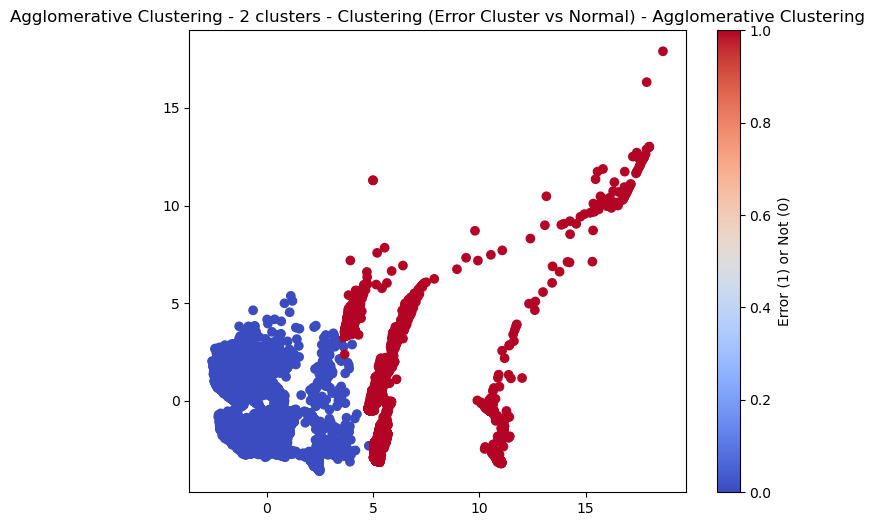


Evaluating with 3 clusters...

Agglomerative Clustering - 3 clusters, Error Cluster: 0
Accuracy: 0.6203
False Positives: 98
False Negatives: 7496
Percentage of Errors Correctly Identified: 25.04%
              precision    recall  f1-score   support

           0       0.57      0.99      0.72     10000
           1       0.96      0.25      0.40     10000

    accuracy                           0.62     20000
   macro avg       0.77      0.62      0.56     20000
weighted avg       0.77      0.62      0.56     20000



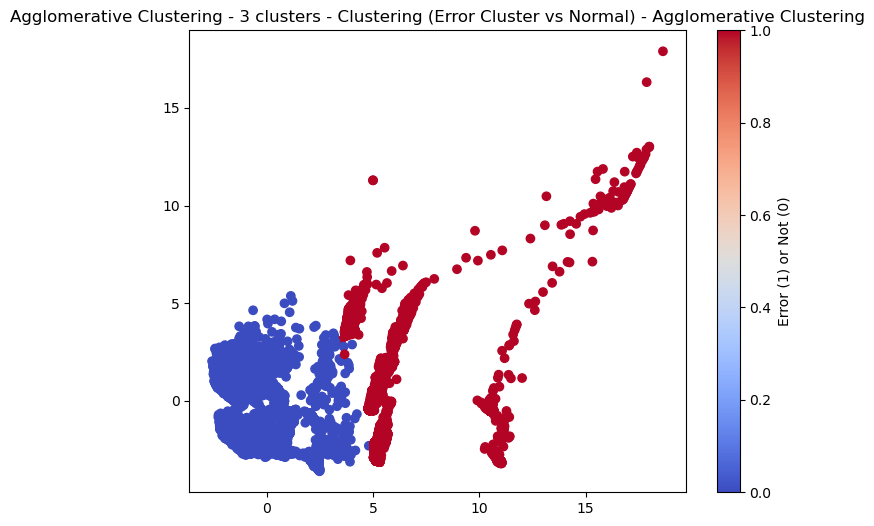


Agglomerative Clustering - 3 clusters, Error Cluster: 1
Accuracy: 0.5724
False Positives: 2411
False Negatives: 6141
Percentage of Errors Correctly Identified: 38.59%
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     10000
           1       0.62      0.39      0.47     10000

    accuracy                           0.57     20000
   macro avg       0.58      0.57      0.56     20000
weighted avg       0.58      0.57      0.56     20000



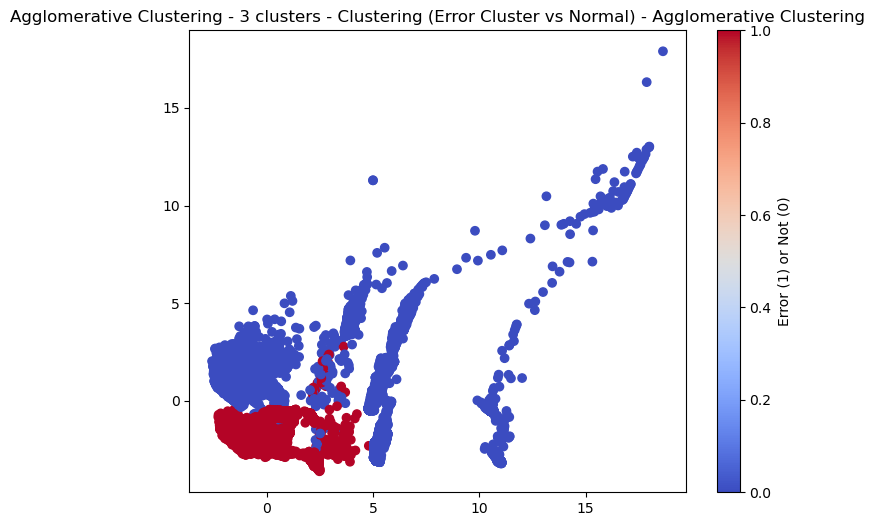


Agglomerative Clustering - 3 clusters, Error Cluster: 2
Accuracy: 0.3073
False Positives: 7491
False Negatives: 6363
Percentage of Errors Correctly Identified: 36.37%
              precision    recall  f1-score   support

           0       0.28      0.25      0.27     10000
           1       0.33      0.36      0.34     10000

    accuracy                           0.31     20000
   macro avg       0.30      0.31      0.31     20000
weighted avg       0.30      0.31      0.31     20000



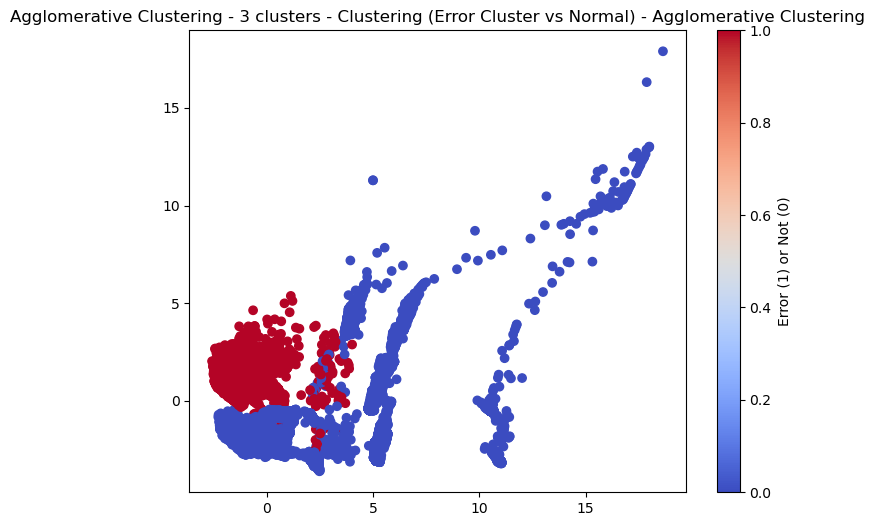


Evaluating with 4 clusters...

Agglomerative Clustering - 4 clusters, Error Cluster: 0
Accuracy: 0.5311
False Positives: 57
False Negatives: 9322
Percentage of Errors Correctly Identified: 6.78%
              precision    recall  f1-score   support

           0       0.52      0.99      0.68     10000
           1       0.92      0.07      0.13     10000

    accuracy                           0.53     20000
   macro avg       0.72      0.53      0.40     20000
weighted avg       0.72      0.53      0.40     20000



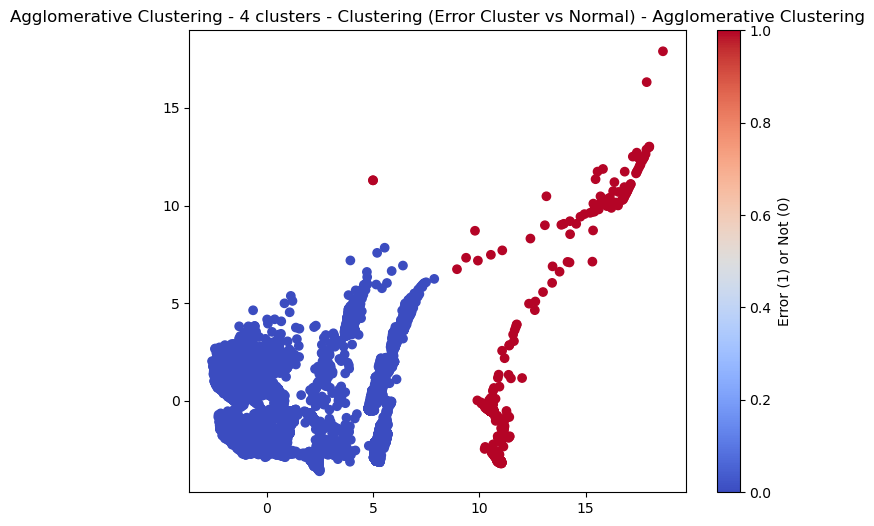


Agglomerative Clustering - 4 clusters, Error Cluster: 1
Accuracy: 0.5724
False Positives: 2411
False Negatives: 6141
Percentage of Errors Correctly Identified: 38.59%
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     10000
           1       0.62      0.39      0.47     10000

    accuracy                           0.57     20000
   macro avg       0.58      0.57      0.56     20000
weighted avg       0.58      0.57      0.56     20000



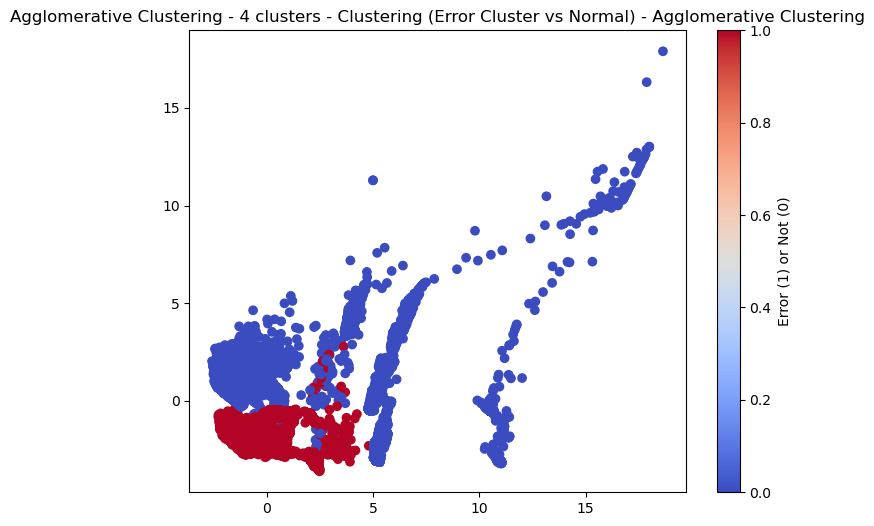


Agglomerative Clustering - 4 clusters, Error Cluster: 2
Accuracy: 0.3073
False Positives: 7491
False Negatives: 6363
Percentage of Errors Correctly Identified: 36.37%
              precision    recall  f1-score   support

           0       0.28      0.25      0.27     10000
           1       0.33      0.36      0.34     10000

    accuracy                           0.31     20000
   macro avg       0.30      0.31      0.31     20000
weighted avg       0.30      0.31      0.31     20000



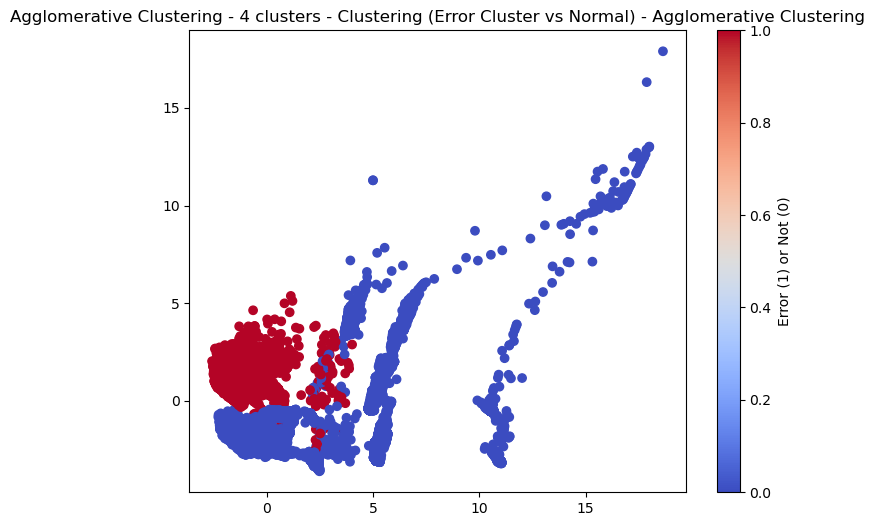


Agglomerative Clustering - 4 clusters, Error Cluster: 3
Accuracy: 0.5893
False Positives: 41
False Negatives: 8174
Percentage of Errors Correctly Identified: 18.26%
              precision    recall  f1-score   support

           0       0.55      1.00      0.71     10000
           1       0.98      0.18      0.31     10000

    accuracy                           0.59     20000
   macro avg       0.76      0.59      0.51     20000
weighted avg       0.76      0.59      0.51     20000



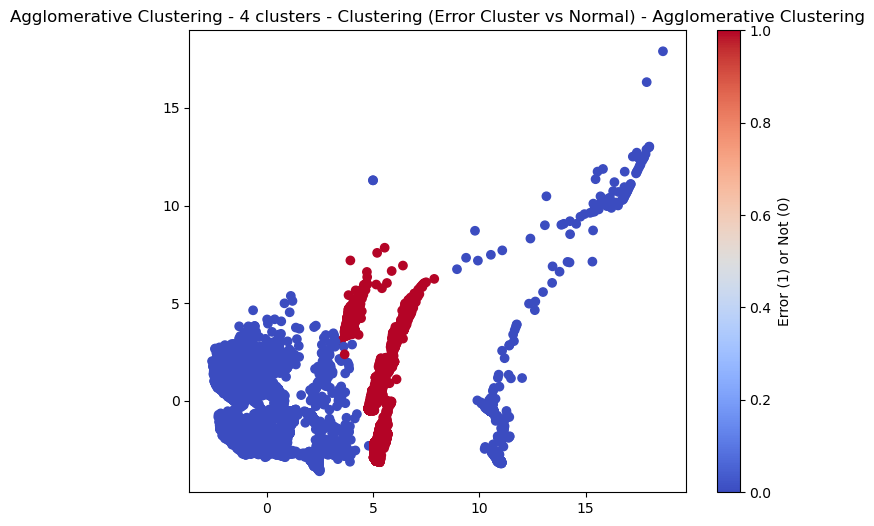


Evaluating with 5 clusters...

Agglomerative Clustering - 5 clusters, Error Cluster: 0
Accuracy: 0.5724
False Positives: 2411
False Negatives: 6141
Percentage of Errors Correctly Identified: 38.59%
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     10000
           1       0.62      0.39      0.47     10000

    accuracy                           0.57     20000
   macro avg       0.58      0.57      0.56     20000
weighted avg       0.58      0.57      0.56     20000



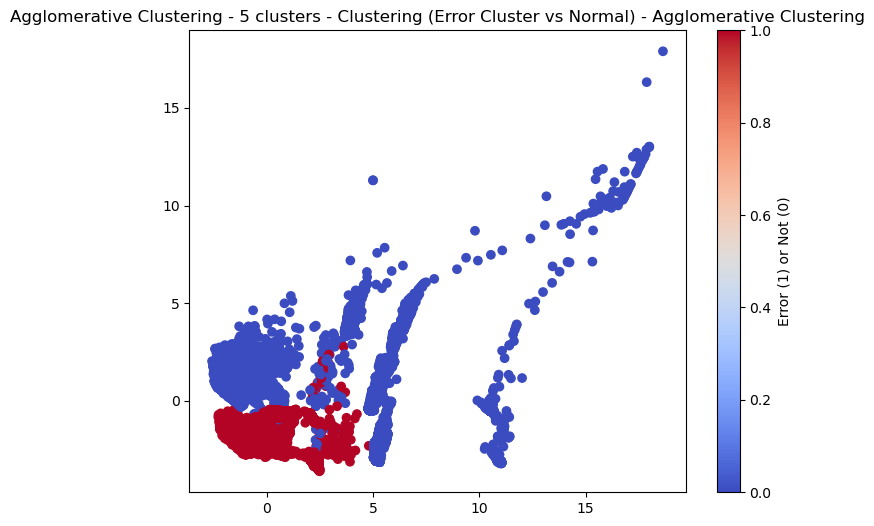


Agglomerative Clustering - 5 clusters, Error Cluster: 1
Accuracy: 0.5893
False Positives: 41
False Negatives: 8174
Percentage of Errors Correctly Identified: 18.26%
              precision    recall  f1-score   support

           0       0.55      1.00      0.71     10000
           1       0.98      0.18      0.31     10000

    accuracy                           0.59     20000
   macro avg       0.76      0.59      0.51     20000
weighted avg       0.76      0.59      0.51     20000



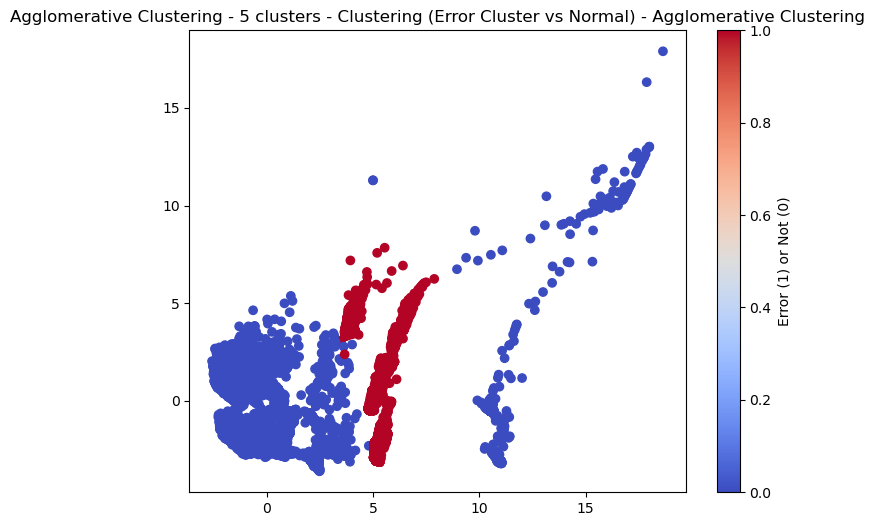


Agglomerative Clustering - 5 clusters, Error Cluster: 2
Accuracy: 0.3073
False Positives: 7491
False Negatives: 6363
Percentage of Errors Correctly Identified: 36.37%
              precision    recall  f1-score   support

           0       0.28      0.25      0.27     10000
           1       0.33      0.36      0.34     10000

    accuracy                           0.31     20000
   macro avg       0.30      0.31      0.31     20000
weighted avg       0.30      0.31      0.31     20000



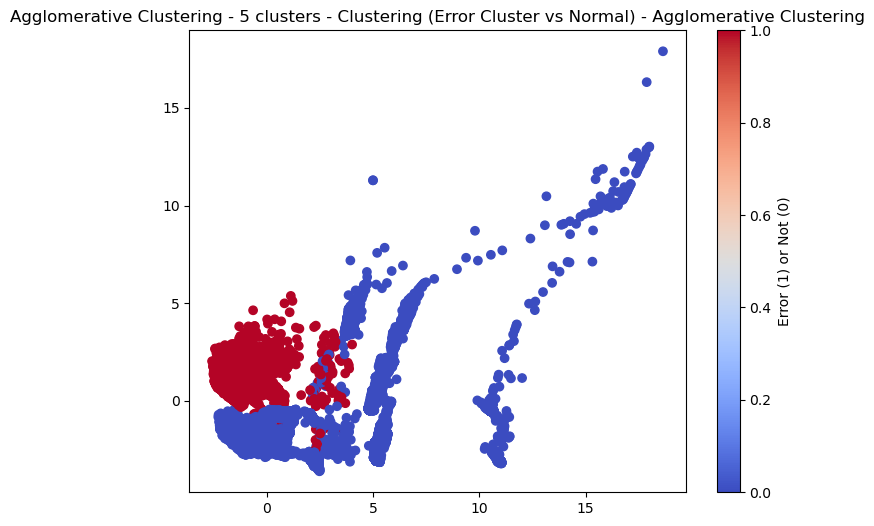


Agglomerative Clustering - 5 clusters, Error Cluster: 3
Accuracy: 0.5275
False Positives: 51
False Negatives: 9398
Percentage of Errors Correctly Identified: 6.02%
              precision    recall  f1-score   support

           0       0.51      0.99      0.68     10000
           1       0.92      0.06      0.11     10000

    accuracy                           0.53     20000
   macro avg       0.72      0.53      0.40     20000
weighted avg       0.72      0.53      0.40     20000



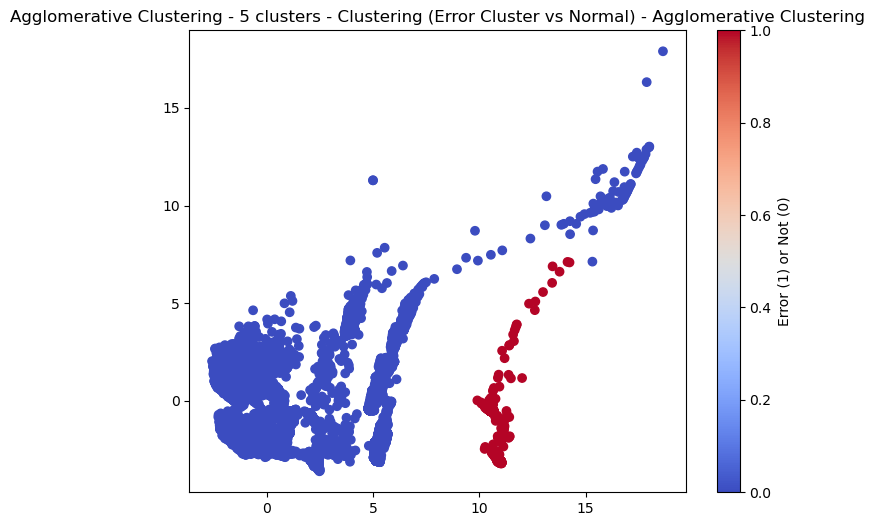


Agglomerative Clustering - 5 clusters, Error Cluster: 4
Accuracy: 0.5035
False Positives: 6
False Negatives: 9924
Percentage of Errors Correctly Identified: 0.76%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10000
           1       0.93      0.01      0.02     10000

    accuracy                           0.50     20000
   macro avg       0.71      0.50      0.34     20000
weighted avg       0.71      0.50      0.34     20000



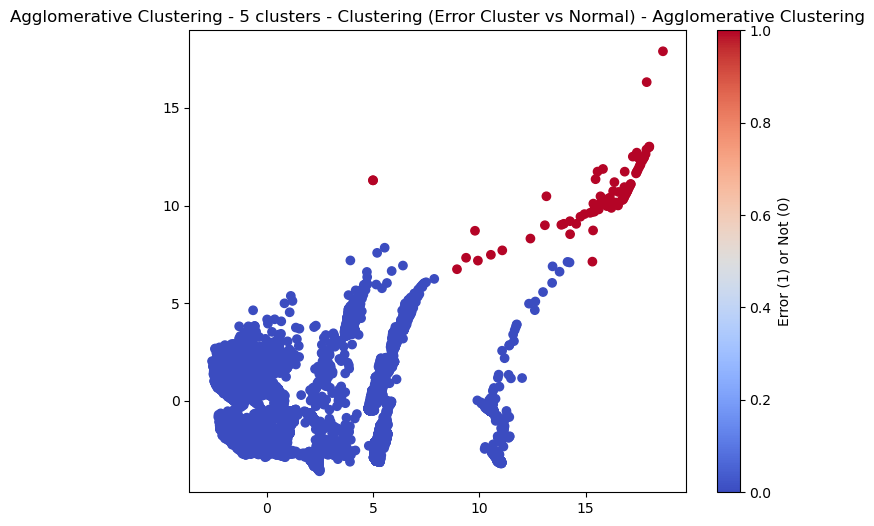


Evaluating with 2 clusters...

Gaussian Mixture Model - 2 clusters, Error Cluster: 0
Accuracy: 0.3353
False Positives: 9062
False Negatives: 4232
Percentage of Errors Correctly Identified: 57.68%
              precision    recall  f1-score   support

           0       0.18      0.09      0.12     10000
           1       0.39      0.58      0.46     10000

    accuracy                           0.34     20000
   macro avg       0.29      0.34      0.29     20000
weighted avg       0.29      0.34      0.29     20000



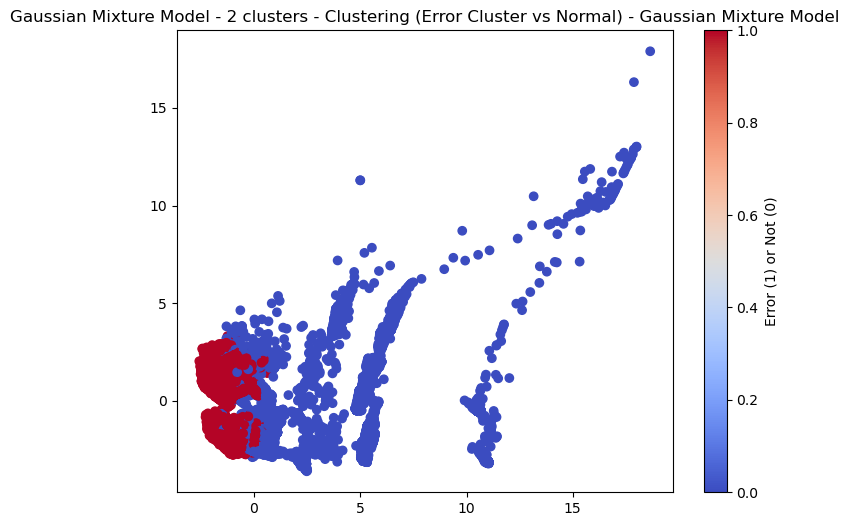


Gaussian Mixture Model - 2 clusters, Error Cluster: 1
Accuracy: 0.6647
False Positives: 938
False Negatives: 5768
Percentage of Errors Correctly Identified: 42.32%
              precision    recall  f1-score   support

           0       0.61      0.91      0.73     10000
           1       0.82      0.42      0.56     10000

    accuracy                           0.66     20000
   macro avg       0.71      0.66      0.64     20000
weighted avg       0.71      0.66      0.64     20000



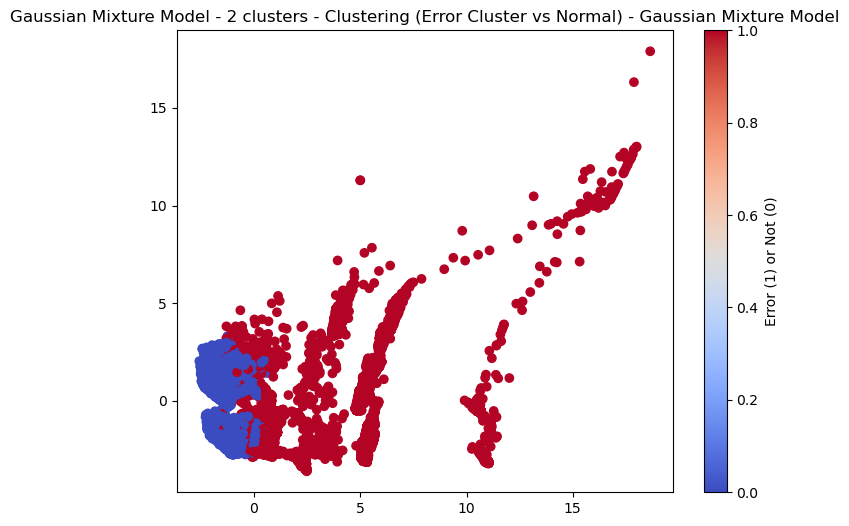


Evaluating with 3 clusters...

Gaussian Mixture Model - 3 clusters, Error Cluster: 0
Accuracy: 0.3065
False Positives: 7227
False Negatives: 6643
Percentage of Errors Correctly Identified: 33.57%
              precision    recall  f1-score   support

           0       0.29      0.28      0.29     10000
           1       0.32      0.34      0.33     10000

    accuracy                           0.31     20000
   macro avg       0.31      0.31      0.31     20000
weighted avg       0.31      0.31      0.31     20000



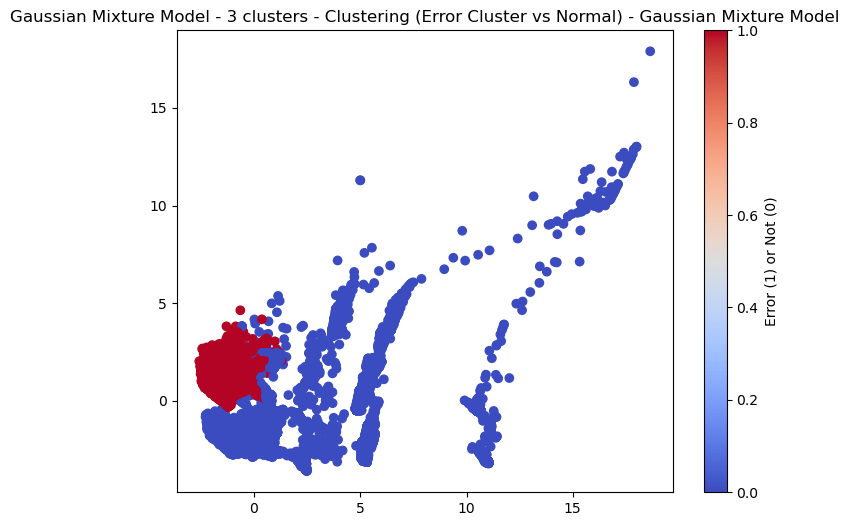


Gaussian Mixture Model - 3 clusters, Error Cluster: 1
Accuracy: 0.6105
False Positives: 294
False Negatives: 7496
Percentage of Errors Correctly Identified: 25.04%
              precision    recall  f1-score   support

           0       0.56      0.97      0.71     10000
           1       0.89      0.25      0.39     10000

    accuracy                           0.61     20000
   macro avg       0.73      0.61      0.55     20000
weighted avg       0.73      0.61      0.55     20000



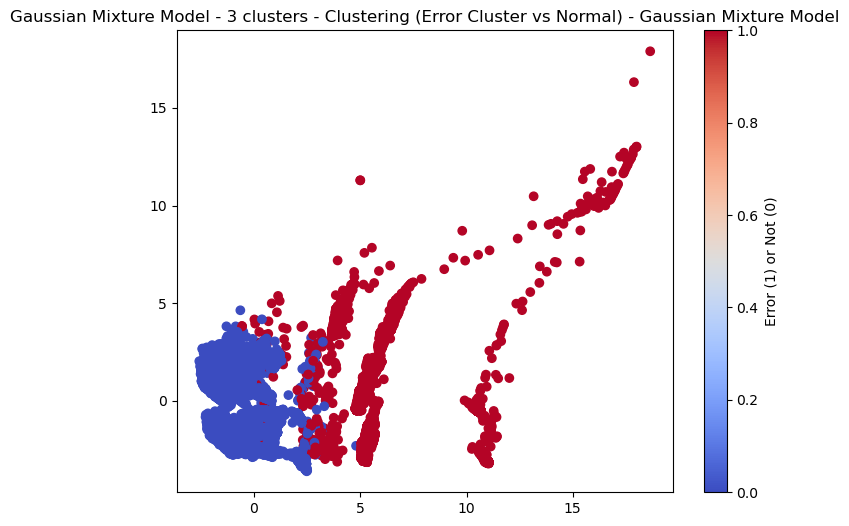


Gaussian Mixture Model - 3 clusters, Error Cluster: 2
Accuracy: 0.5830
False Positives: 2479
False Negatives: 5861
Percentage of Errors Correctly Identified: 41.39%
              precision    recall  f1-score   support

           0       0.56      0.75      0.64     10000
           1       0.63      0.41      0.50     10000

    accuracy                           0.58     20000
   macro avg       0.59      0.58      0.57     20000
weighted avg       0.59      0.58      0.57     20000



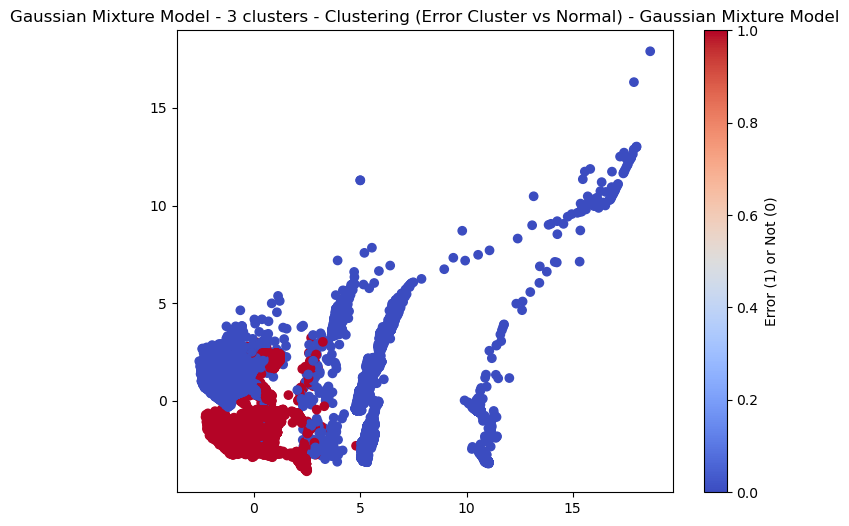


Evaluating with 4 clusters...

Gaussian Mixture Model - 4 clusters, Error Cluster: 0
Accuracy: 0.5806
False Positives: 1623
False Negatives: 6764
Percentage of Errors Correctly Identified: 32.36%
              precision    recall  f1-score   support

           0       0.55      0.84      0.67     10000
           1       0.67      0.32      0.44     10000

    accuracy                           0.58     20000
   macro avg       0.61      0.58      0.55     20000
weighted avg       0.61      0.58      0.55     20000



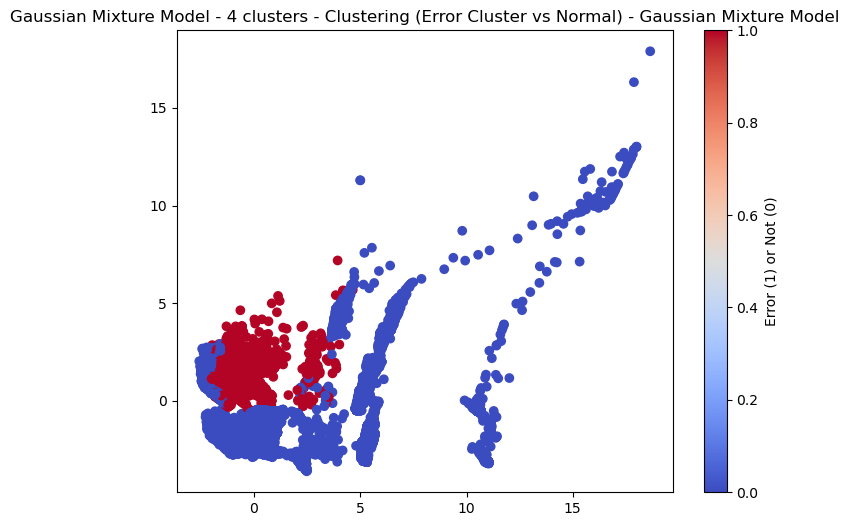


Gaussian Mixture Model - 4 clusters, Error Cluster: 1
Accuracy: 0.6177
False Positives: 150
False Negatives: 7496
Percentage of Errors Correctly Identified: 25.04%
              precision    recall  f1-score   support

           0       0.57      0.98      0.72     10000
           1       0.94      0.25      0.40     10000

    accuracy                           0.62     20000
   macro avg       0.76      0.62      0.56     20000
weighted avg       0.76      0.62      0.56     20000



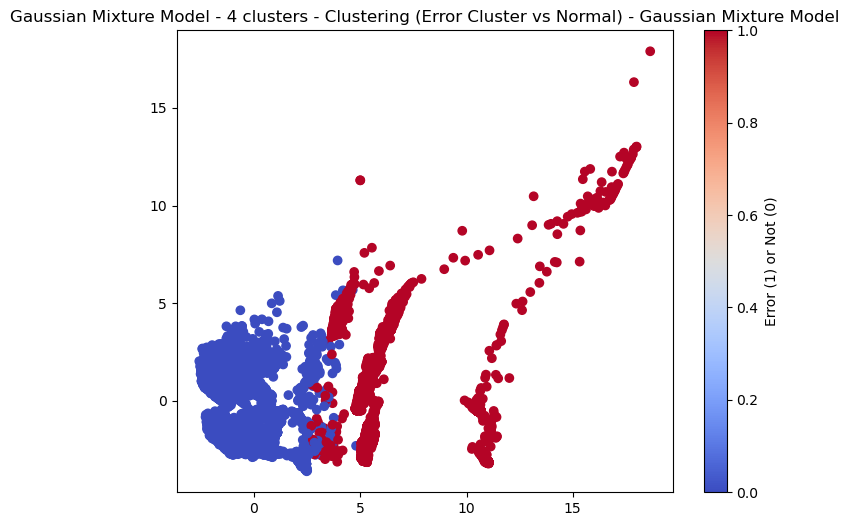


Gaussian Mixture Model - 4 clusters, Error Cluster: 2
Accuracy: 0.2278
False Positives: 5846
False Negatives: 9599
Percentage of Errors Correctly Identified: 4.01%
              precision    recall  f1-score   support

           0       0.30      0.42      0.35     10000
           1       0.06      0.04      0.05     10000

    accuracy                           0.23     20000
   macro avg       0.18      0.23      0.20     20000
weighted avg       0.18      0.23      0.20     20000



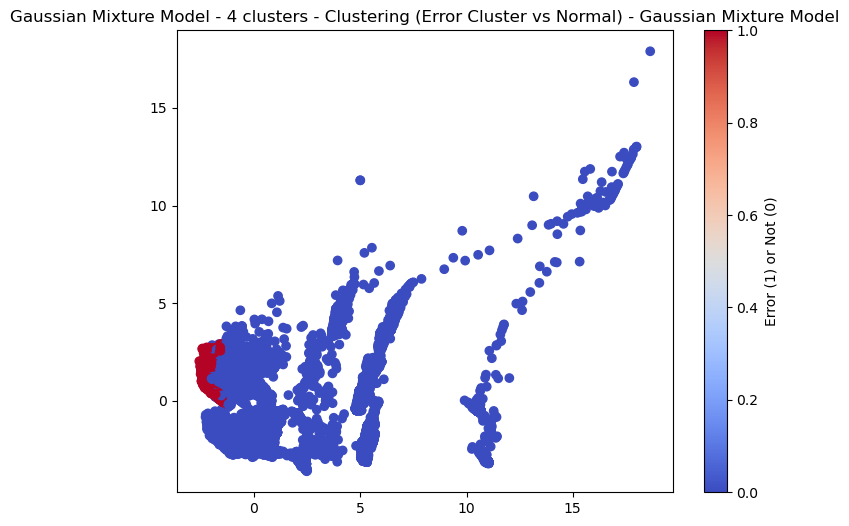


Gaussian Mixture Model - 4 clusters, Error Cluster: 3
Accuracy: 0.5739
False Positives: 2381
False Negatives: 6141
Percentage of Errors Correctly Identified: 38.59%
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     10000
           1       0.62      0.39      0.48     10000

    accuracy                           0.57     20000
   macro avg       0.59      0.57      0.56     20000
weighted avg       0.59      0.57      0.56     20000



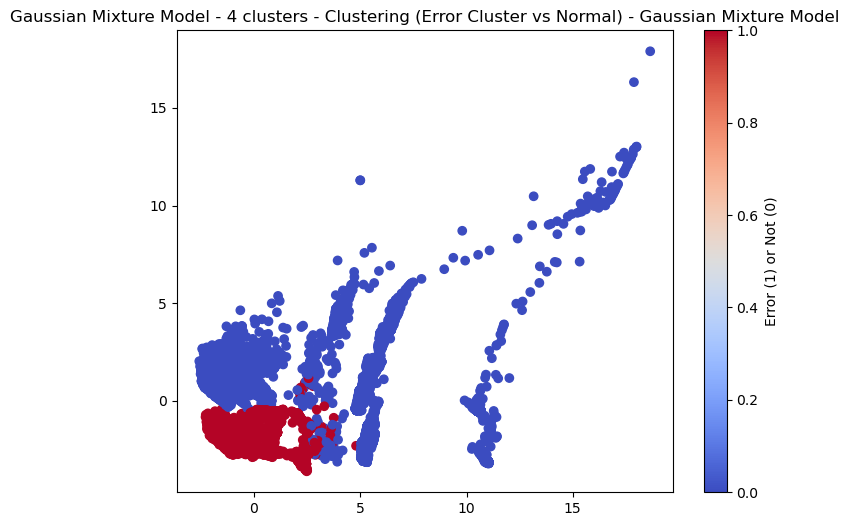


Evaluating with 5 clusters...

Gaussian Mixture Model - 5 clusters, Error Cluster: 0
Accuracy: 0.5855
False Positives: 1535
False Negatives: 6756
Percentage of Errors Correctly Identified: 32.44%
              precision    recall  f1-score   support

           0       0.56      0.85      0.67     10000
           1       0.68      0.32      0.44     10000

    accuracy                           0.59     20000
   macro avg       0.62      0.59      0.56     20000
weighted avg       0.62      0.59      0.56     20000



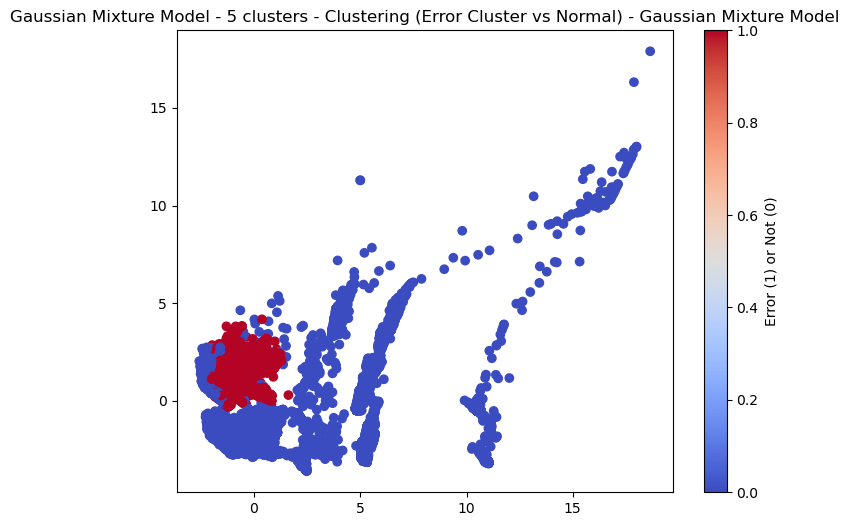


Gaussian Mixture Model - 5 clusters, Error Cluster: 1
Accuracy: 0.5869
False Positives: 52
False Negatives: 8209
Percentage of Errors Correctly Identified: 17.91%
              precision    recall  f1-score   support

           0       0.55      0.99      0.71     10000
           1       0.97      0.18      0.30     10000

    accuracy                           0.59     20000
   macro avg       0.76      0.59      0.50     20000
weighted avg       0.76      0.59      0.50     20000



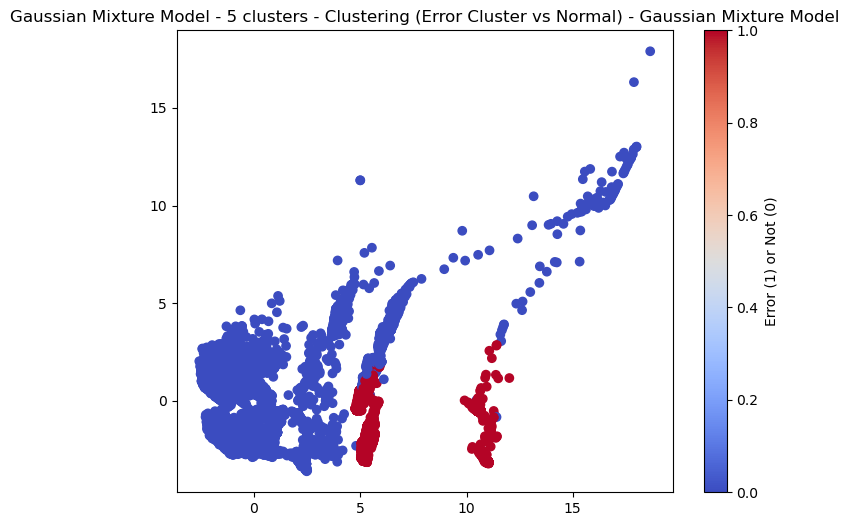


Gaussian Mixture Model - 5 clusters, Error Cluster: 2
Accuracy: 0.2303
False Positives: 5788
False Negatives: 9607
Percentage of Errors Correctly Identified: 3.93%
              precision    recall  f1-score   support

           0       0.30      0.42      0.35     10000
           1       0.06      0.04      0.05     10000

    accuracy                           0.23     20000
   macro avg       0.18      0.23      0.20     20000
weighted avg       0.18      0.23      0.20     20000



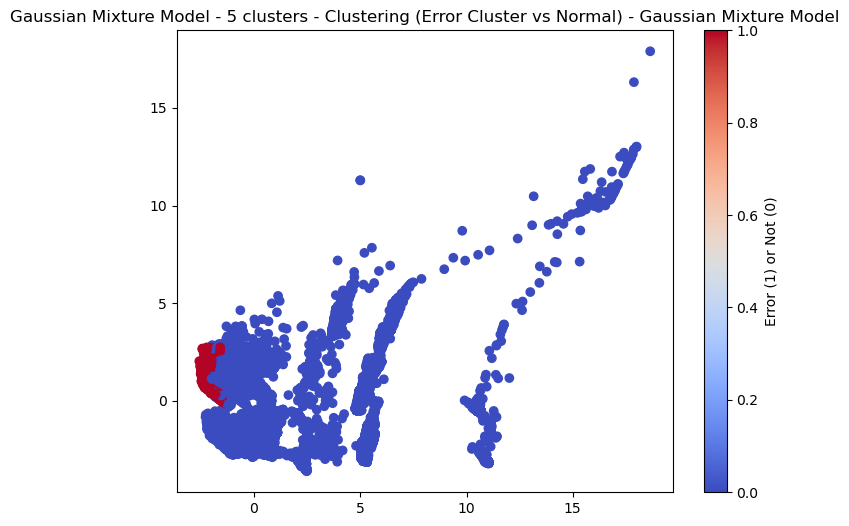


Gaussian Mixture Model - 5 clusters, Error Cluster: 3
Accuracy: 0.5631
False Positives: 2393
False Negatives: 6346
Percentage of Errors Correctly Identified: 36.54%
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     10000
           1       0.60      0.37      0.46     10000

    accuracy                           0.56     20000
   macro avg       0.57      0.56      0.55     20000
weighted avg       0.57      0.56      0.55     20000



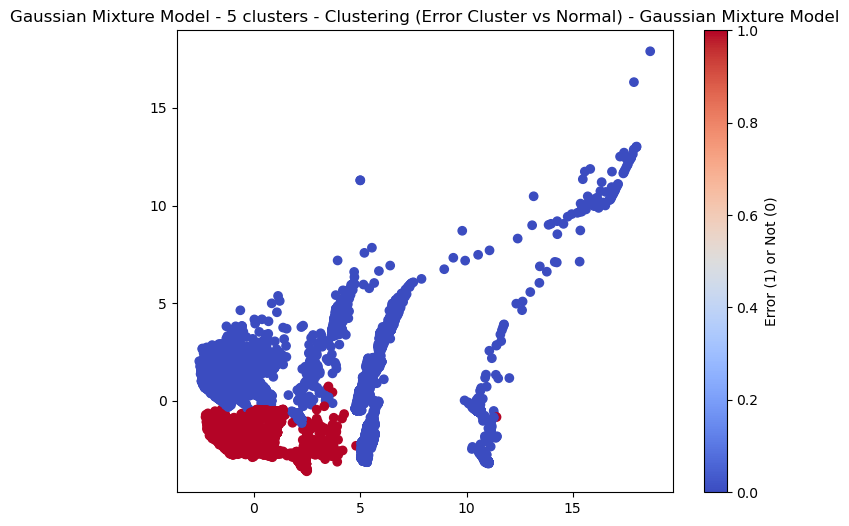


Gaussian Mixture Model - 5 clusters, Error Cluster: 4
Accuracy: 0.5343
False Positives: 232
False Negatives: 9082
Percentage of Errors Correctly Identified: 9.18%
              precision    recall  f1-score   support

           0       0.52      0.98      0.68     10000
           1       0.80      0.09      0.16     10000

    accuracy                           0.53     20000
   macro avg       0.66      0.53      0.42     20000
weighted avg       0.66      0.53      0.42     20000



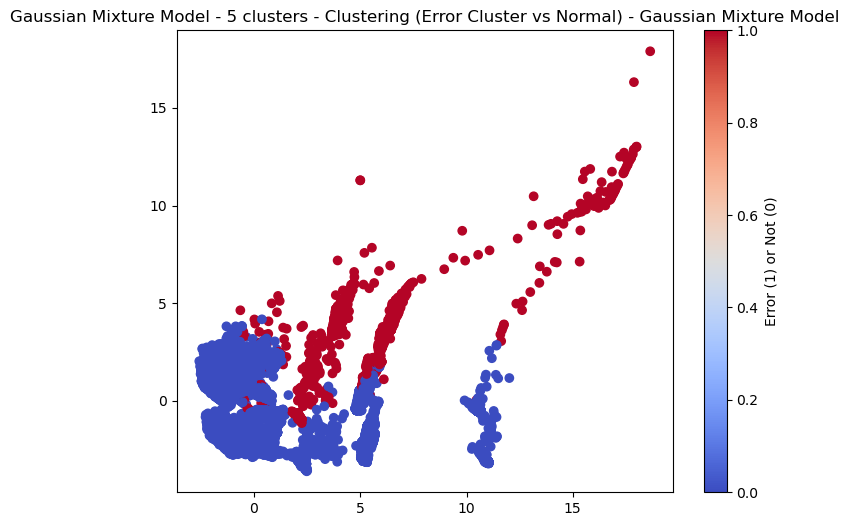


Evaluating with 2 clusters...

Mean Shift - 2 clusters, Error Cluster: 0
Accuracy: 0.3629
False Positives: 9588
False Negatives: 3154
Percentage of Errors Correctly Identified: 68.46%
              precision    recall  f1-score   support

           0       0.12      0.04      0.06     10000
           1       0.42      0.68      0.52     10000

    accuracy                           0.36     20000
   macro avg       0.27      0.36      0.29     20000
weighted avg       0.27      0.36      0.29     20000



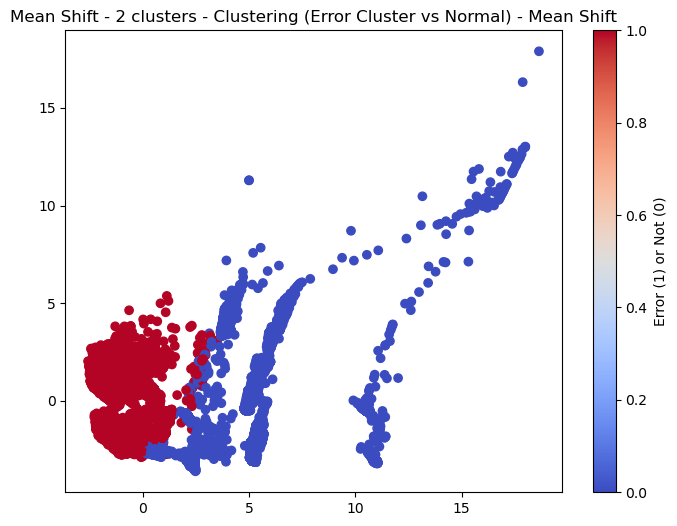


Mean Shift - 2 clusters, Error Cluster: 1
Accuracy: 0.5840
False Positives: 123
False Negatives: 8197
Percentage of Errors Correctly Identified: 18.03%
              precision    recall  f1-score   support

           0       0.55      0.99      0.70     10000
           1       0.94      0.18      0.30     10000

    accuracy                           0.58     20000
   macro avg       0.74      0.58      0.50     20000
weighted avg       0.74      0.58      0.50     20000



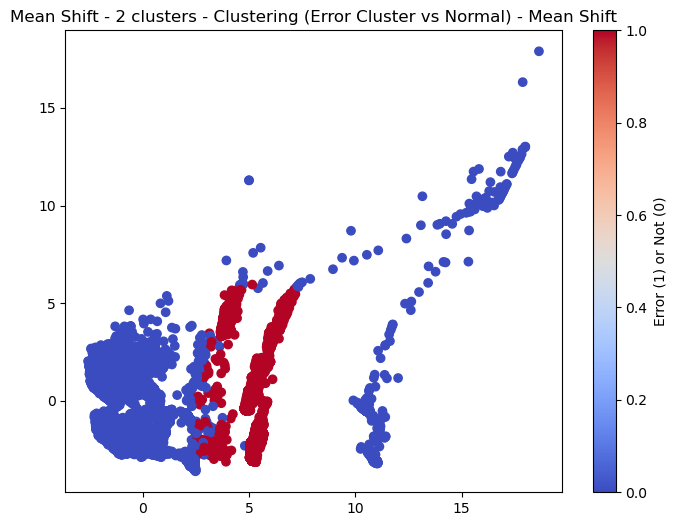


Evaluating with 3 clusters...

Mean Shift - 3 clusters, Error Cluster: 0
Accuracy: 0.3629
False Positives: 9588
False Negatives: 3154
Percentage of Errors Correctly Identified: 68.46%
              precision    recall  f1-score   support

           0       0.12      0.04      0.06     10000
           1       0.42      0.68      0.52     10000

    accuracy                           0.36     20000
   macro avg       0.27      0.36      0.29     20000
weighted avg       0.27      0.36      0.29     20000



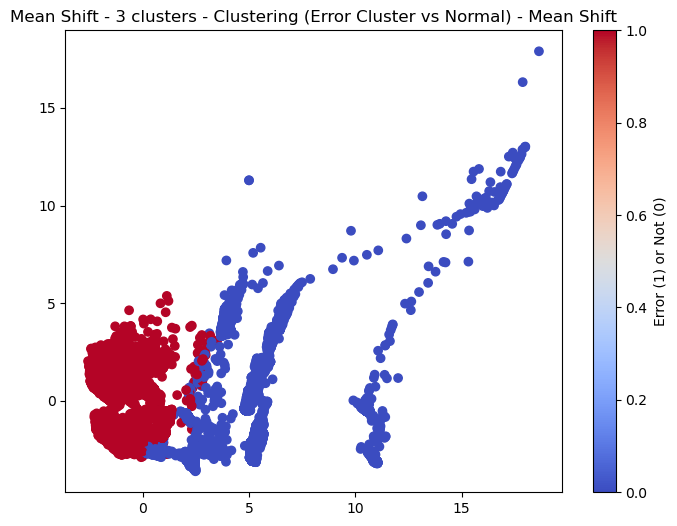


Mean Shift - 3 clusters, Error Cluster: 1
Accuracy: 0.5840
False Positives: 123
False Negatives: 8197
Percentage of Errors Correctly Identified: 18.03%
              precision    recall  f1-score   support

           0       0.55      0.99      0.70     10000
           1       0.94      0.18      0.30     10000

    accuracy                           0.58     20000
   macro avg       0.74      0.58      0.50     20000
weighted avg       0.74      0.58      0.50     20000



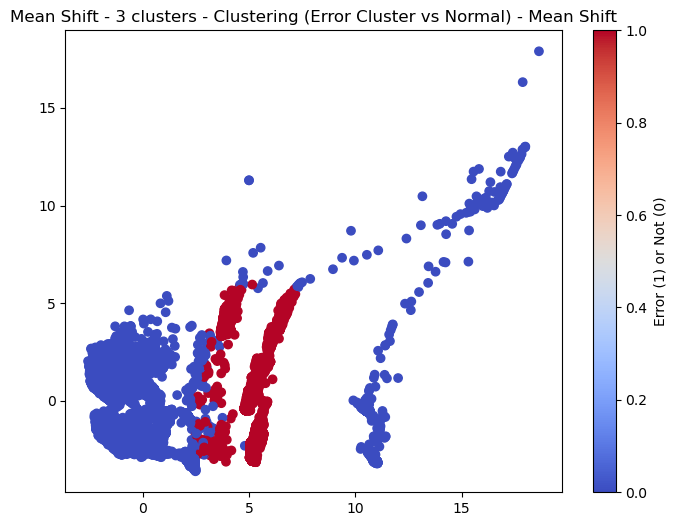


Mean Shift - 3 clusters, Error Cluster: 2
Accuracy: 0.5214
False Positives: 221
False Negatives: 9350
Percentage of Errors Correctly Identified: 6.50%
              precision    recall  f1-score   support

           0       0.51      0.98      0.67     10000
           1       0.75      0.07      0.12     10000

    accuracy                           0.52     20000
   macro avg       0.63      0.52      0.40     20000
weighted avg       0.63      0.52      0.40     20000



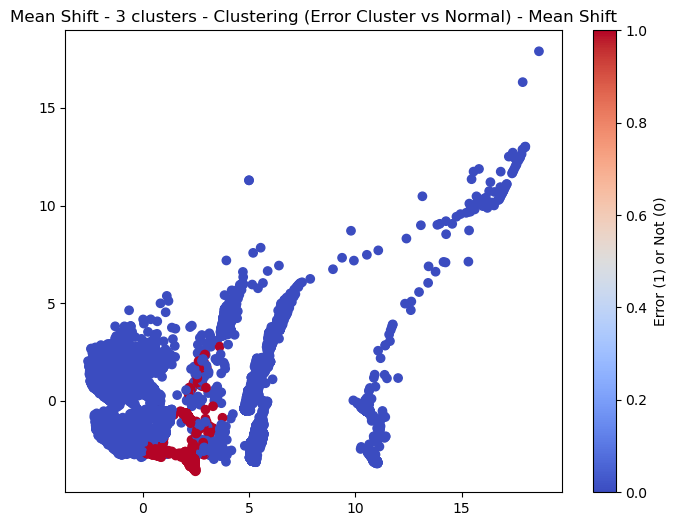


Evaluating with 4 clusters...

Mean Shift - 4 clusters, Error Cluster: 0
Accuracy: 0.3629
False Positives: 9588
False Negatives: 3154
Percentage of Errors Correctly Identified: 68.46%
              precision    recall  f1-score   support

           0       0.12      0.04      0.06     10000
           1       0.42      0.68      0.52     10000

    accuracy                           0.36     20000
   macro avg       0.27      0.36      0.29     20000
weighted avg       0.27      0.36      0.29     20000



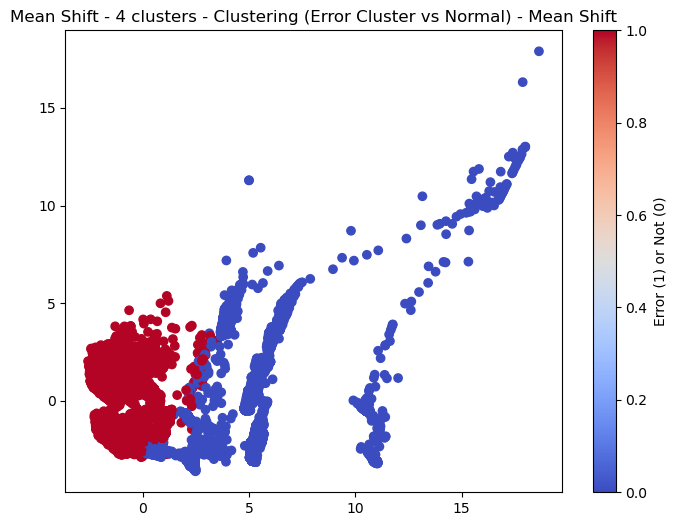


Mean Shift - 4 clusters, Error Cluster: 1
Accuracy: 0.5840
False Positives: 123
False Negatives: 8197
Percentage of Errors Correctly Identified: 18.03%
              precision    recall  f1-score   support

           0       0.55      0.99      0.70     10000
           1       0.94      0.18      0.30     10000

    accuracy                           0.58     20000
   macro avg       0.74      0.58      0.50     20000
weighted avg       0.74      0.58      0.50     20000



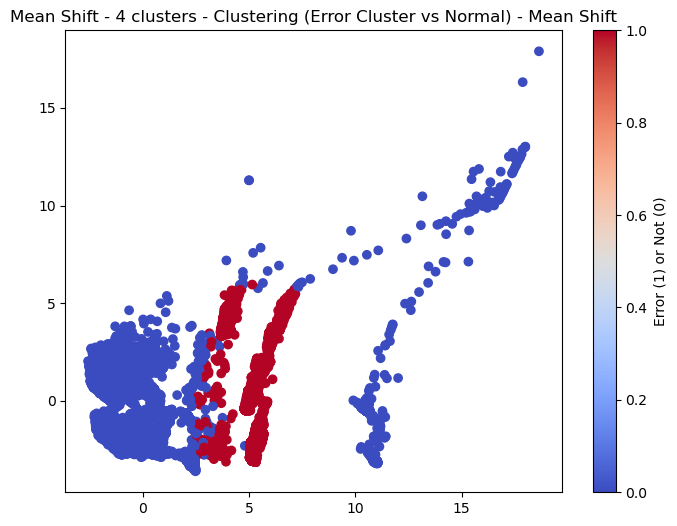


Mean Shift - 4 clusters, Error Cluster: 2
Accuracy: 0.5214
False Positives: 221
False Negatives: 9350
Percentage of Errors Correctly Identified: 6.50%
              precision    recall  f1-score   support

           0       0.51      0.98      0.67     10000
           1       0.75      0.07      0.12     10000

    accuracy                           0.52     20000
   macro avg       0.63      0.52      0.40     20000
weighted avg       0.63      0.52      0.40     20000



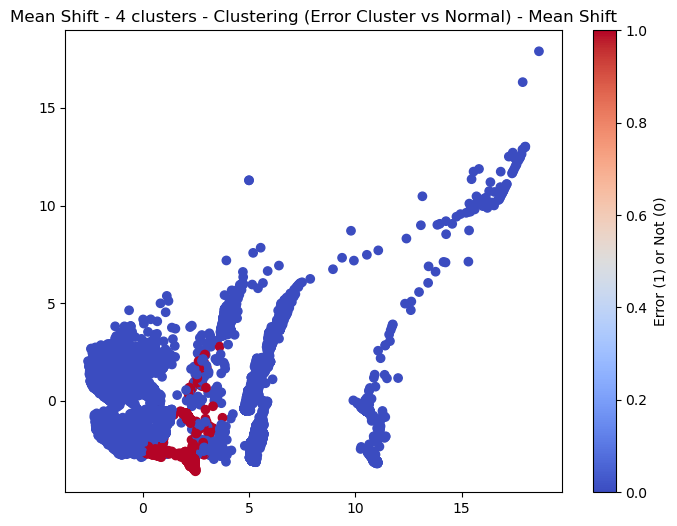


Mean Shift - 4 clusters, Error Cluster: 3
Accuracy: 0.5271
False Positives: 49
False Negatives: 9409
Percentage of Errors Correctly Identified: 5.91%
              precision    recall  f1-score   support

           0       0.51      1.00      0.68     10000
           1       0.92      0.06      0.11     10000

    accuracy                           0.53     20000
   macro avg       0.72      0.53      0.39     20000
weighted avg       0.72      0.53      0.39     20000



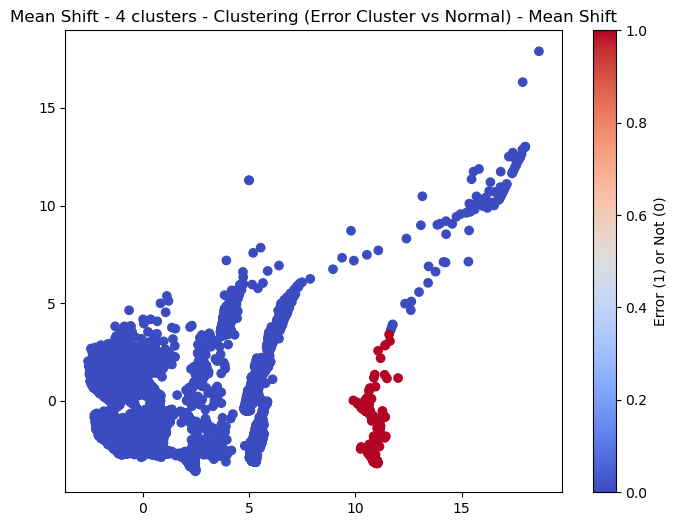


Evaluating with 5 clusters...

Mean Shift - 5 clusters, Error Cluster: 0
Accuracy: 0.3629
False Positives: 9588
False Negatives: 3154
Percentage of Errors Correctly Identified: 68.46%
              precision    recall  f1-score   support

           0       0.12      0.04      0.06     10000
           1       0.42      0.68      0.52     10000

    accuracy                           0.36     20000
   macro avg       0.27      0.36      0.29     20000
weighted avg       0.27      0.36      0.29     20000



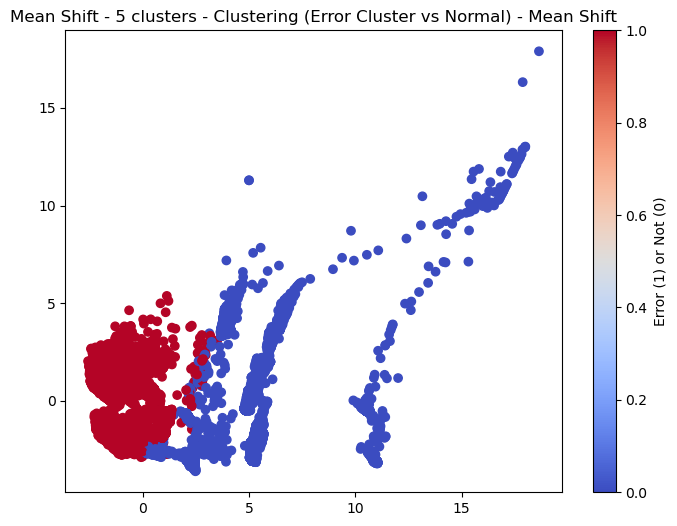


Mean Shift - 5 clusters, Error Cluster: 1
Accuracy: 0.5840
False Positives: 123
False Negatives: 8197
Percentage of Errors Correctly Identified: 18.03%
              precision    recall  f1-score   support

           0       0.55      0.99      0.70     10000
           1       0.94      0.18      0.30     10000

    accuracy                           0.58     20000
   macro avg       0.74      0.58      0.50     20000
weighted avg       0.74      0.58      0.50     20000



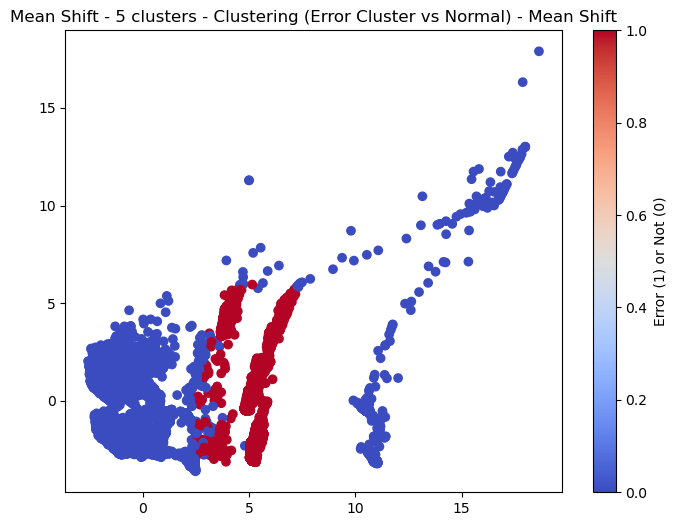


Mean Shift - 5 clusters, Error Cluster: 2
Accuracy: 0.5214
False Positives: 221
False Negatives: 9350
Percentage of Errors Correctly Identified: 6.50%
              precision    recall  f1-score   support

           0       0.51      0.98      0.67     10000
           1       0.75      0.07      0.12     10000

    accuracy                           0.52     20000
   macro avg       0.63      0.52      0.40     20000
weighted avg       0.63      0.52      0.40     20000



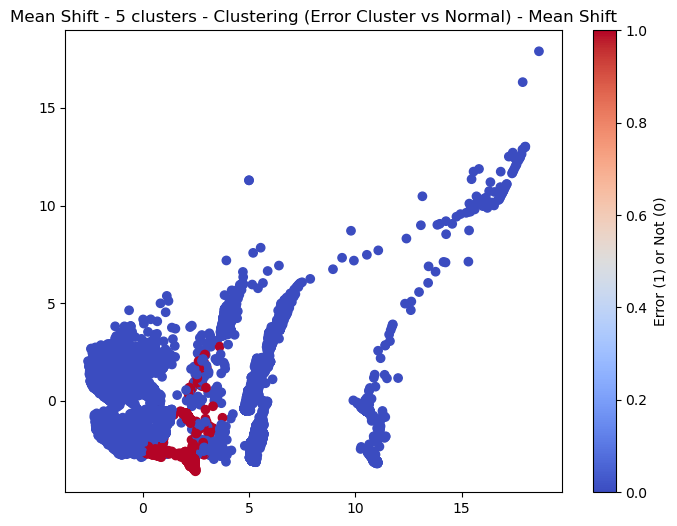


Mean Shift - 5 clusters, Error Cluster: 3
Accuracy: 0.5271
False Positives: 49
False Negatives: 9409
Percentage of Errors Correctly Identified: 5.91%
              precision    recall  f1-score   support

           0       0.51      1.00      0.68     10000
           1       0.92      0.06      0.11     10000

    accuracy                           0.53     20000
   macro avg       0.72      0.53      0.39     20000
weighted avg       0.72      0.53      0.39     20000



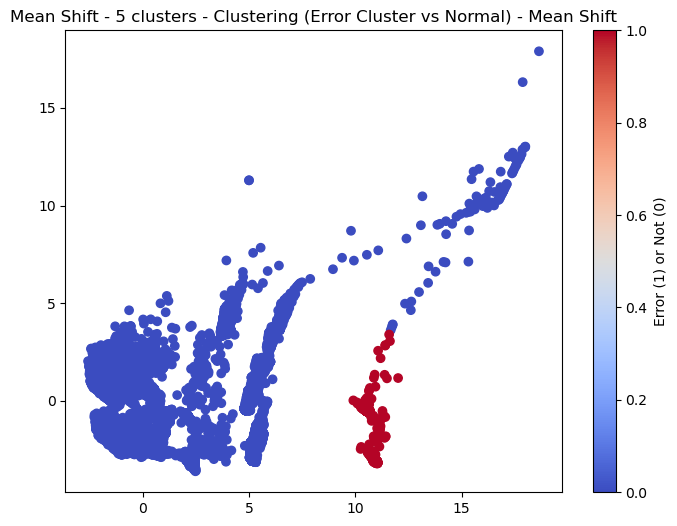


Mean Shift - 5 clusters, Error Cluster: 4
Accuracy: 0.5031
False Positives: 1
False Negatives: 9936
Percentage of Errors Correctly Identified: 0.64%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10000
           1       0.98      0.01      0.01     10000

    accuracy                           0.50     20000
   macro avg       0.74      0.50      0.34     20000
weighted avg       0.74      0.50      0.34     20000



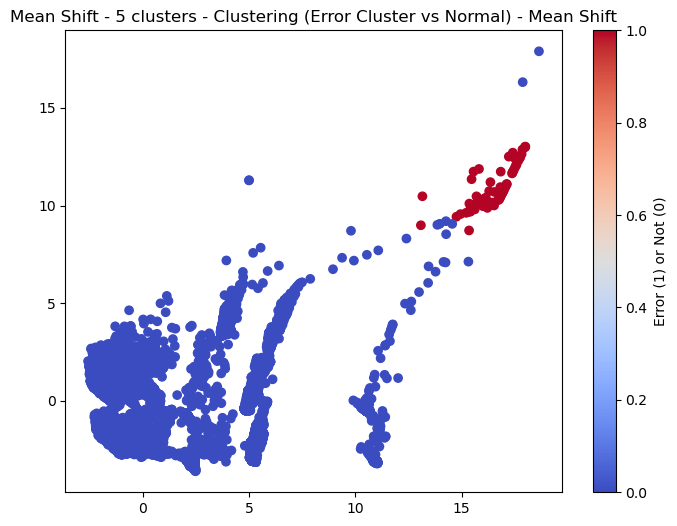

In [20]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to evaluate and visualize the clustering
def evaluate_clustering_with_different_cluster_sizes(clustering_model, name, features_scaled, true_labels, cluster_sizes):
    for n_clusters in cluster_sizes:
        print(f"\nEvaluating with {n_clusters} clusters...")

        # Update the model's number of clusters
        if hasattr(clustering_model, 'n_clusters'):
            clustering_model.n_clusters = n_clusters
        elif isinstance(clustering_model, GaussianMixture):
            clustering_model.n_components = n_clusters
        
        # Fit the model
        clustering_model.fit(features_scaled)
        
        # Get the cluster labels
        cluster_labels = clustering_model.labels_ if hasattr(clustering_model, 'labels_') else clustering_model.predict(features_scaled)
        
        # Handle DBSCAN noise (-1) and treat it as errors
        if np.any(cluster_labels == -1):
            cluster_labels = np.where(cluster_labels == -1, len(set(cluster_labels)), cluster_labels)  # Convert -1 (noise) to a new cluster
        
        # Iterate over each cluster and treat it as error (1) and the rest as normal (0)
        cluster_sizes = np.bincount(cluster_labels)
        for error_cluster in range(n_clusters):
            y_pred_binary = (cluster_labels == error_cluster).astype(int)  # Mark error cluster as 1, others as 0
            
            # Evaluation metrics
            tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
            accuracy = accuracy_score(true_labels, y_pred_binary)
            percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
            
            print(f"\n{name} - {n_clusters} clusters, Error Cluster: {error_cluster}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"False Positives: {fp}")
            print(f"False Negatives: {fn}")
            print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
            print(classification_report(true_labels, y_pred_binary))
            
            # Visualize the clusters
            visualize_clusters(features_scaled, cluster_labels, error_cluster, name, n_clusters, f"{name} - {n_clusters} clusters")

# Function for visualizing the clustering results
def visualize_clusters(features_scaled, cluster_labels, error_cluster, model_name, n_clusters, title, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot the data points, color-coded by their cluster label (normal vs. error)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(cluster_labels == error_cluster), cmap='coolwarm')
    plt.title(f"{title} - Clustering (Error Cluster vs Normal) - {model_name}")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Try different clustering methods and cluster sizes
clustering_models = [
    (KMeans(random_state=42), "KMeans"),
    (DBSCAN(), "DBSCAN"),
    (AgglomerativeClustering(), "Agglomerative Clustering"),
    (GaussianMixture(random_state=42), "Gaussian Mixture Model"),
    (MeanShift(), "Mean Shift")
]

# Define the range of cluster sizes to evaluate
cluster_sizes_to_evaluate = [2, 3, 4, 5]

# Iterate over clustering models and evaluate them with different numbers of clusters
for model, name in clustering_models:
    evaluate_clustering_with_different_cluster_sizes(model, name, features_resampled, target_resampled, cluster_sizes_to_evaluate)


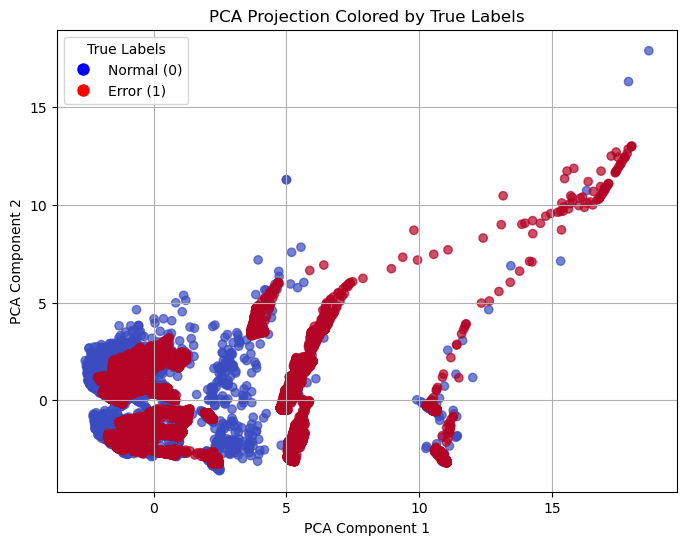

In [21]:
def visualize_true_labels(features_scaled, true_labels, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=true_labels, cmap='coolwarm', alpha=0.7)
    legend_labels = {0: 'Normal (0)', 1: 'Error (1)'}
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[label],
                          markerfacecolor=clr, markersize=10)
               for label, clr in zip([0, 1], ['blue', 'red'])]
    plt.legend(handles=handles, title='True Labels')
    plt.title("PCA Projection Colored by True Labels")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

visualize_true_labels(features_resampled, target_resampled)


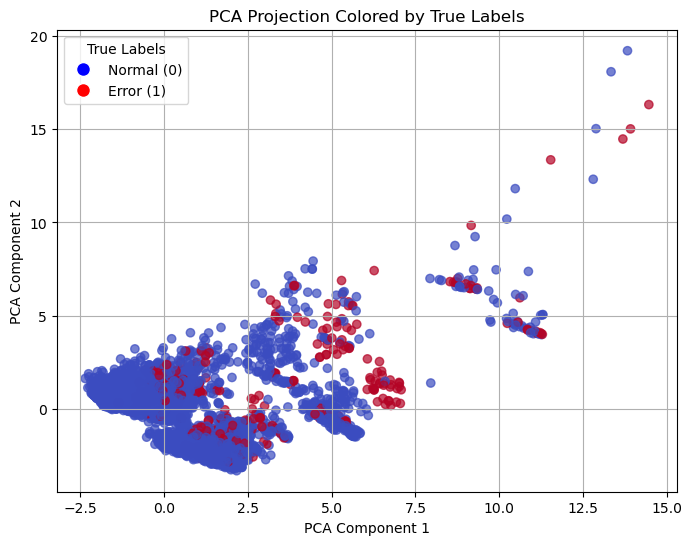

In [27]:
def visualize_true_labels(features_scaled, true_labels, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=true_labels, cmap='coolwarm', alpha=0.7)
    legend_labels = {0: 'Normal (0)', 1: 'Error (1)'}
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[label],
                          markerfacecolor=clr, markersize=10)
               for label, clr in zip([0, 1], ['blue', 'red'])]
    plt.legend(handles=handles, title='True Labels')
    plt.title("PCA Projection Colored by True Labels")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

visualize_true_labels(features_scaled, target)



326/326 [==============================] - 0s 900us/step
Autoencoder Evaluation:
Accuracy: 0.7465
F1-score: 0.1264
False Positives: 2414
False Negatives: 227
Percentage of Errors Correctly Identified: 45.69%
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     10000
           1       0.07      0.46      0.13       418

    accuracy                           0.75     10418
   macro avg       0.52      0.61      0.49     10418
weighted avg       0.93      0.75      0.82     10418


Isolation Forest Evaluation:
Accuracy: 0.9346
F1-score: 0.2748
False Positives: 392
False Negatives: 289
Percentage of Errors Correctly Identified: 30.86%
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10000
           1       0.25      0.31      0.27       418

    accuracy                           0.93     10418
   macro avg       0.61      0.63      0.62     10418
weighted avg       0.94      0.93   

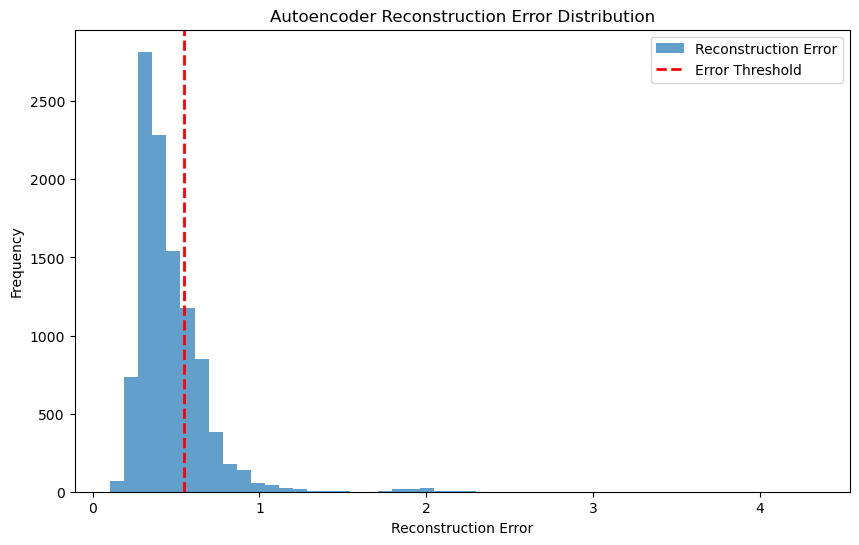

In [38]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt


# 1. **Autoencoder Model**
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Train Autoencoder on normal data (non-error data)
autoencoder = build_autoencoder(features_scaled.shape[1])
autoencoder.fit(features_scaled, features_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Calculate reconstruction error
reconstructed = autoencoder.predict(features_scaled)
reconstruction_error = np.mean(np.abs(reconstructed - features_scaled), axis=1)

# Define a threshold for reconstruction error (error if reconstruction error is high)
threshold_autoencoder = np.percentile(reconstruction_error, 75)  # Choose threshold based on error distribution
y_pred_autoencoder = (reconstruction_error > threshold_autoencoder).astype(int)

# 2. **Isolation Forest**
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
y_pred_isolation_forest = isolation_forest.fit_predict(features_scaled)
y_pred_isolation_forest = (y_pred_isolation_forest == -1).astype(int)  # -1 indicates anomaly

# Evaluate both methods
def evaluate_model(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * tp / (2 * tp + fp + fn)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    return accuracy, f1, tn, fp, fn, tp, percent_errors_identified

# Evaluate Autoencoder results
accuracy_autoencoder, f1_autoencoder, tn_autoencoder, fp_autoencoder, fn_autoencoder, tp_autoencoder, percent_errors_autoencoder = evaluate_model(target, y_pred_autoencoder)

# Evaluate Isolation Forest results
accuracy_isolation_forest, f1_isolation_forest, tn_if, fp_if, fn_if, tp_if, percent_errors_if = evaluate_model(target, y_pred_isolation_forest)

# Print results
print("Autoencoder Evaluation:")
print(f"Accuracy: {accuracy_autoencoder:.4f}")
print(f"F1-score: {f1_autoencoder:.4f}")
print(f"False Positives: {fp_autoencoder}")
print(f"False Negatives: {fn_autoencoder}")
print(f"Percentage of Errors Correctly Identified: {percent_errors_autoencoder:.2f}%")
print(classification_report(target, y_pred_autoencoder))

print("\nIsolation Forest Evaluation:")
print(f"Accuracy: {accuracy_isolation_forest:.4f}")
print(f"F1-score: {f1_isolation_forest:.4f}")
print(f"False Positives: {fp_if}")
print(f"False Negatives: {fn_if}")
print(f"Percentage of Errors Correctly Identified: {percent_errors_if:.2f}%")
print(classification_report(target, y_pred_isolation_forest))

# Visualize Autoencoder reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.7, label="Reconstruction Error")
plt.axvline(threshold_autoencoder, color='r', linestyle='dashed', linewidth=2, label="Error Threshold")
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Epoch 1/50

33/33 [==============================] - 1s 6ms/step - loss: 1.2101 - val_loss: 1.0933
Epoch 2/50

33/33 [==============================] - 0s 3ms/step - loss: 1.0893 - val_loss: 0.9810
Epoch 3/50

33/33 [==============================] - 0s 3ms/step - loss: 0.9792 - val_loss: 0.8789
Epoch 4/50

33/33 [==============================] - 0s 3ms/step - loss: 0.8845 - val_loss: 0.7944
Epoch 5/50

33/33 [==============================] - 0s 3ms/step - loss: 0.8100 - val_loss: 0.7313
Epoch 6/50

33/33 [==============================] - 0s 3ms/step - loss: 0.7569 - val_loss: 0.6879
Epoch 7/50

33/33 [==============================] - 0s 3ms/step - loss: 0.7208 - val_loss: 0.6583
Epoch 8/50

33/33 [==============================] - 0s 3ms/step - loss: 0.6959 - val_loss: 0.6378
Epoch 9/50

33/33 [==============================] - 0s 3ms/step - loss: 0.6782 - val_loss: 0.6227
Epoch 10/50

33/33 [==============================] - 0s 3ms/step - loss: 0.6650 - val_loss: 0.6114
Epoch 11/

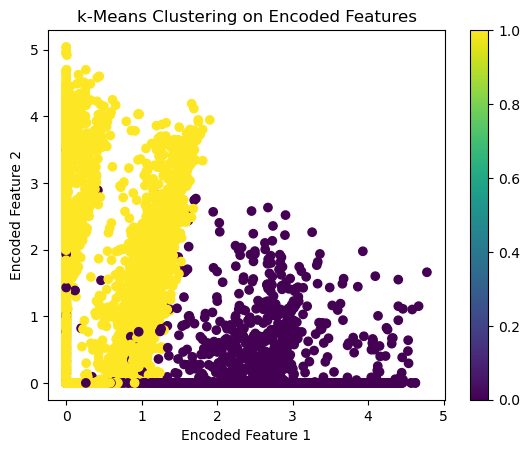

In [37]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Function to train Autoencoder
def train_autoencoder(features, encoding_dim=32):
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Define Autoencoder model architecture
    input_layer = Input(shape=(features_scaled.shape[1],))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(features_scaled.shape[1], activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train Autoencoder
    autoencoder.fit(features_scaled, features_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)
    
    # Encoder part to get the encoded representation
    encoder = Model(input_layer, encoded)
    encoded_features = encoder.predict(features_scaled)
    
    return encoded_features, scaler

# Function to apply k-Means clustering to the encoded features
def kmeans_clustering(encoded_features, num_clusters=2):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(encoded_features)
    return cluster_labels, kmeans

# Function to classify anomalies based on k-Means clusters
def classify_anomalies(cluster_labels, num_clusters=2, max_anomalies_percentage=0.1):
    # Identify clusters and their sizes
    unique, counts = np.unique(cluster_labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))

    # Sort the clusters by size (smallest first, assuming minority error cluster is small)
    sorted_clusters = sorted(cluster_sizes, key=lambda x: cluster_sizes[x])

    # Calculate the maximum number of anomalies based on the percentage
    total_points = len(cluster_labels)
    max_anomalies = int(total_points * max_anomalies_percentage)

    # Start by treating the smallest clusters as anomalies, up to the max allowed
    anomalies = np.zeros(len(cluster_labels))
    anomaly_cluster = sorted_clusters[0]  # smallest cluster

    # Label the smallest cluster as anomalies
    anomalies[cluster_labels == anomaly_cluster] = 1

    # If needed, you can consider other small clusters as anomalies
    remaining_anomalies = max_anomalies - np.sum(anomalies)
    for cluster in sorted_clusters[1:]:
        if remaining_anomalies <= 0:
            break
        additional_anomalies = np.minimum(np.sum(cluster_labels == cluster), remaining_anomalies)
        anomalies[cluster_labels == cluster] = 1
        remaining_anomalies -= additional_anomalies

    return anomalies

# Function to evaluate the anomaly detection model
def evaluate_model(true_labels, predicted_labels):
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Train Autoencoder and apply k-Means clustering
encoded_features, scaler = train_autoencoder(features_scaled)

# Apply k-Means clustering to the encoded features
cluster_labels, kmeans = kmeans_clustering(encoded_features)

# Classify anomalies based on the clustering
anomalies = classify_anomalies(cluster_labels, max_anomalies_percentage=0.02)

# Evaluate the model performance
evaluate_model(target, anomalies)

# Optionally, visualize the clustering result
plt.scatter(encoded_features[:, 0], encoded_features[:, 1], c=cluster_labels, cmap='viridis')
plt.title('k-Means Clustering on Encoded Features')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.colorbar()
plt.show()


In [40]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_isolation_forest(features, target, contamination=0.05):
    # Train Isolation Forest
    model = IsolationForest(contamination=contamination)
    model.fit(features)

    # Predict anomalies (errors)
    y_pred = model.predict(features)
    # Isolation Forest returns -1 for anomalies and 1 for normal points
    y_pred_binary = np.where(y_pred == -1, 1, 0)

    # Evaluation
    print("\nClassification Report (Isolation Forest):")
    print(classification_report(target, y_pred_binary))

    tn, fp, fn, tp = confusion_matrix(target, y_pred_binary).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Apply Isolation Forest
evaluate_isolation_forest(features_resampled, target_resampled, contamination=0.05)  # Set contamination to 5% for a small minority




Classification Report (Isolation Forest):
              precision    recall  f1-score   support

           0       0.51      0.98      0.67     10000
           1       0.77      0.08      0.14     10000

    accuracy                           0.53     20000
   macro avg       0.64      0.53      0.41     20000
weighted avg       0.64      0.53      0.41     20000

F1-score: 0.1395
False Positives: 233
False Negatives: 9233
Percentage of Errors Correctly Identified: 7.67%


In [41]:
from sklearn.neighbors import LocalOutlierFactor

def evaluate_lof(features, target, n_neighbors=20):
    # Train LOF model
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    y_pred = lof.fit_predict(features)
    # LOF returns -1 for anomalies and 1 for normal points
    y_pred_binary = np.where(y_pred == -1, 1, 0)

    # Evaluation
    print("\nClassification Report (LOF):")
    print(classification_report(target, y_pred_binary))

    tn, fp, fn, tp = confusion_matrix(target, y_pred_binary).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Apply LOF anomaly detection
evaluate_lof(features_scaled, target)



Classification Report (LOF):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10000
           1       0.03      0.05      0.04       418

    accuracy                           0.90     10418
   macro avg       0.50      0.49      0.49     10418
weighted avg       0.92      0.90      0.91     10418

F1-score: 0.0376
False Positives: 627
False Negatives: 398
Percentage of Errors Correctly Identified: 4.78%


In [42]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_pca_anomaly(features, target, n_components=2, threshold_percentile=95):
    # Fit PCA model
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)

    # Reconstruct the original data
    features_reconstructed = pca.inverse_transform(features_pca)

    # Compute the reconstruction error (Euclidean distance)
    reconstruction_error = np.linalg.norm(features - features_reconstructed, axis=1)

    # Determine anomaly threshold (e.g., top 5% highest reconstruction errors)
    threshold = np.percentile(reconstruction_error, threshold_percentile)
    
    # Classify as anomaly (1) if reconstruction error exceeds the threshold
    y_pred_binary = (reconstruction_error > threshold).astype(int)

    # Evaluation
    print("\nClassification Report (PCA Anomaly Detection):")
    print(classification_report(target, y_pred_binary))

    tn, fp, fn, tp = confusion_matrix(target, y_pred_binary).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Apply PCA anomaly detection
evaluate_pca_anomaly(features_scaled, target)



Classification Report (PCA Anomaly Detection):
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10000
           1       0.15      0.19      0.17       418

    accuracy                           0.93     10418
   macro avg       0.56      0.57      0.56     10418
weighted avg       0.93      0.93      0.93     10418

F1-score: 0.1683
False Positives: 442
False Negatives: 339
Percentage of Errors Correctly Identified: 18.90%


In [43]:
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance

def evaluate_pca_with_mahalanobis(features, target, variance_threshold=0.95, threshold_percentile=95):
    # Fit PCA and select components based on explained variance
    pca = PCA()
    pca.fit(features)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)

    # Reconstruct the data
    features_reconstructed = pca.inverse_transform(features_pca)

    # Compute reconstruction error
    reconstruction_error = np.linalg.norm(features - features_reconstructed, axis=1)

    # Mahalanobis distance calculation
    covariance_estimator = EmpiricalCovariance().fit(features)
    mahalanobis_distances = []
    for i in range(features.shape[0]):
        dist = mahalanobis(features[i], np.mean(features, axis=0), covariance_estimator.precision_)
        mahalanobis_distances.append(dist)
    
    mahalanobis_distances = np.array(mahalanobis_distances)

    # Combine reconstruction error and Mahalanobis distance for anomaly detection
    threshold_reconstruction = np.percentile(reconstruction_error, threshold_percentile)
    threshold_mahalanobis = np.percentile(mahalanobis_distances, threshold_percentile)

    # Combine both thresholds for anomaly detection
    y_pred_binary = (reconstruction_error > threshold_reconstruction) | (mahalanobis_distances > threshold_mahalanobis)
    
    # Evaluation metrics
    print("\nClassification Report (PCA + Mahalanobis Anomaly Detection):")
    print(classification_report(target, y_pred_binary))

    tn, fp, fn, tp = confusion_matrix(target, y_pred_binary).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Run PCA with Mahalanobis Distance Anomaly Detection
evaluate_pca_with_mahalanobis(features_scaled, target)



Classification Report (PCA + Mahalanobis Anomaly Detection):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10000
           1       0.23      0.35      0.27       418

    accuracy                           0.93     10418
   macro avg       0.60      0.65      0.62     10418
weighted avg       0.94      0.93      0.93     10418

F1-score: 0.2744
False Positives: 494
False Negatives: 273
Percentage of Errors Correctly Identified: 34.69%
